In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Copy data folder from drive to this machine
#!mkdir -p /content/images
# Copy the necessary files.
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/utils.py /content/utils.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/trainer.py /content/trainer.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/scanner.py /content/scanner.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/pruner.py /content/pruner.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/model.py /content/model.py

Mounted at /content/drive


In [2]:
!pip install torchinfo

**Table of contents**<a id='toc0_'></a>    
- [Useful Constants](#toc1_)    
- [Dataloading](#toc2_)    
- [Importing Models and Masks](#toc3_)    
- [Plotting Distribution](#toc4_)    
  - [Unpruned Model](#toc4_1_)    
  - [Finegrained Pruning](#toc4_2_)    
    - [Post Pruning](#toc4_2_1_)    
    - [Fine-tuning](#toc4_2_2_)    
  - [Kernel Pruning](#toc4_3_)    
    - [Post Pruning](#toc4_3_1_)    
    - [Fine-tuned](#toc4_3_2_)    
  - [Filter Pruning](#toc4_4_)    
    - [Post Pruning](#toc4_4_1_)    
    - [Fine-tuned](#toc4_4_2_)    
- [Accuracies of the Models](#toc5_)    
- [Activations](#toc6_)    
  - [Unpruned](#toc6_1_)    
  - [Finegrained](#toc6_2_)    
    - [Post-Pruning](#toc6_2_1_)    
    - [Fine-tuned](#toc6_2_2_)    
  - [Kernel](#toc6_3_)    
    - [Post-Pruning](#toc6_3_1_)    
    - [Fine-tuned](#toc6_3_2_)    
  - [Filter](#toc6_4_)    
    - [Post-Pruning](#toc6_4_1_)    
    - [Fine-tuned](#toc6_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [3]:
import torch
import torch.nn as nn
import torchinfo
import pruner
import model
import trainer
import scanner
import utils
import matplotlib.pyplot as plt
import copy
import numpy as np

# <a id='toc1_'></a>[Useful Constants](#toc0_)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_NAMES = ['conv0',
               'conv1',
               'conv2',
               'conv3',
               'conv4',
               'conv5',
               'conv6',
               'conv7',
               'conv8',
               'conv9',
               'conv10',
               'conv11']

# <a id='toc2_'></a>[Dataloading](#toc0_)

In [5]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, ToTensor, Compose
from torch.utils.data import DataLoader

image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170498071/170498071 [00:01<00:00, 88284276.90it/s] 


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


# <a id='toc3_'></a>[Importing Models and Masks](#toc0_)

In [6]:
def apply_pruning_mask(module: nn.Module,
                       masks: dict):
    """Applies pruning mask to the weights.

    Args:
        module (nn.Module): Module or model to be applied mask to.
        masks (dict): Pruning masks.
    """
    with torch.no_grad():
        for keys in masks:
            weight_mask = masks[keys][0]
            bias_mask = masks[keys][1]
            # Apply mask.
            module._modules[keys].weight.data *= weight_mask
            module._modules[keys].bias.data *= bias_mask

In [7]:
vgg16 = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16_finegrained = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16_kernel = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16_filter = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

In [8]:
vgg16.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [9]:
vgg16_finegrained.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_finegrained.pt',
                                 map_location=torch.device(DEVICE))['model_state_dict'])
finegrained_mask = torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_finegrained.pt',
                                 map_location=torch.device(DEVICE))['prune_masks']

In [10]:
vgg16_kernel.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_kernel.pt',
                                 map_location=torch.device(DEVICE))['model_state_dict'])
kernel_mask = torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_kernel.pt',
                                 map_location=torch.device(DEVICE))['prune_masks']

In [11]:
vgg16_filter.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_filter.pt',
                                 map_location=torch.device(DEVICE))['model_state_dict'])
filter_mask = torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_filter.pt',
                                 map_location=torch.device(DEVICE))['prune_masks']

Creating post-pruned versions of the models (Before finetuning)

In [12]:
vgg16_finegrained_pp = copy.deepcopy(vgg16)
apply_pruning_mask(vgg16_finegrained_pp.features, finegrained_mask)

In [13]:
vgg16_kernel_pp = copy.deepcopy(vgg16)
apply_pruning_mask(vgg16_kernel_pp.features, kernel_mask)

In [14]:
vgg16_filter_pp = copy.deepcopy(vgg16)
apply_pruning_mask(vgg16_filter_pp.features, filter_mask)

# <a id='toc4_'></a>[Plotting Distribution](#toc0_)

Functions

In [39]:
def plot_weight_distribution(module: nn.Module, layer_names: list[str] = LAYER_NAMES, x_lim=None, pruned=True):
    """
    Plots the weight distribution of specified layers in a neural network model.

    Parameters:
    - model (torch.nn.Module): The neural network model from which to plot the weight distributions.
    - layer_names (list of str): A list of strings that correspond to the names of the model's layers
                                 whose weights are to be plotted.
    - y_lim (int): An optional integer to set an upper limit on the y-axis of the plots.
    - pruned (bool): Wheter model is pruned or not.
    """
    num_layers = len(layer_names)
    num_columns = 3
    num_rows = num_layers // num_columns + (num_layers % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows), constrained_layout=True)

    # Flatten the axis array for easy iteration
    axs = axs.flatten()

    for ax, layer_name in zip(axs, layer_names):
        layer = module._modules[layer_name]
        weights = layer.weight.data.cpu().numpy().flatten()
        if pruned:
          weights = weights[weights != 0]
        ax.hist(weights, bins=50, color='steelblue', edgecolor='black')
        ax.set_title(f'{layer_name}')
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')
        if x_lim:
            ax.set_xlim([-x_lim, x_lim])

    plt.tight_layout()
    plt.show()




## <a id='toc4_1_'></a>[Unpruned Model](#toc0_)

<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


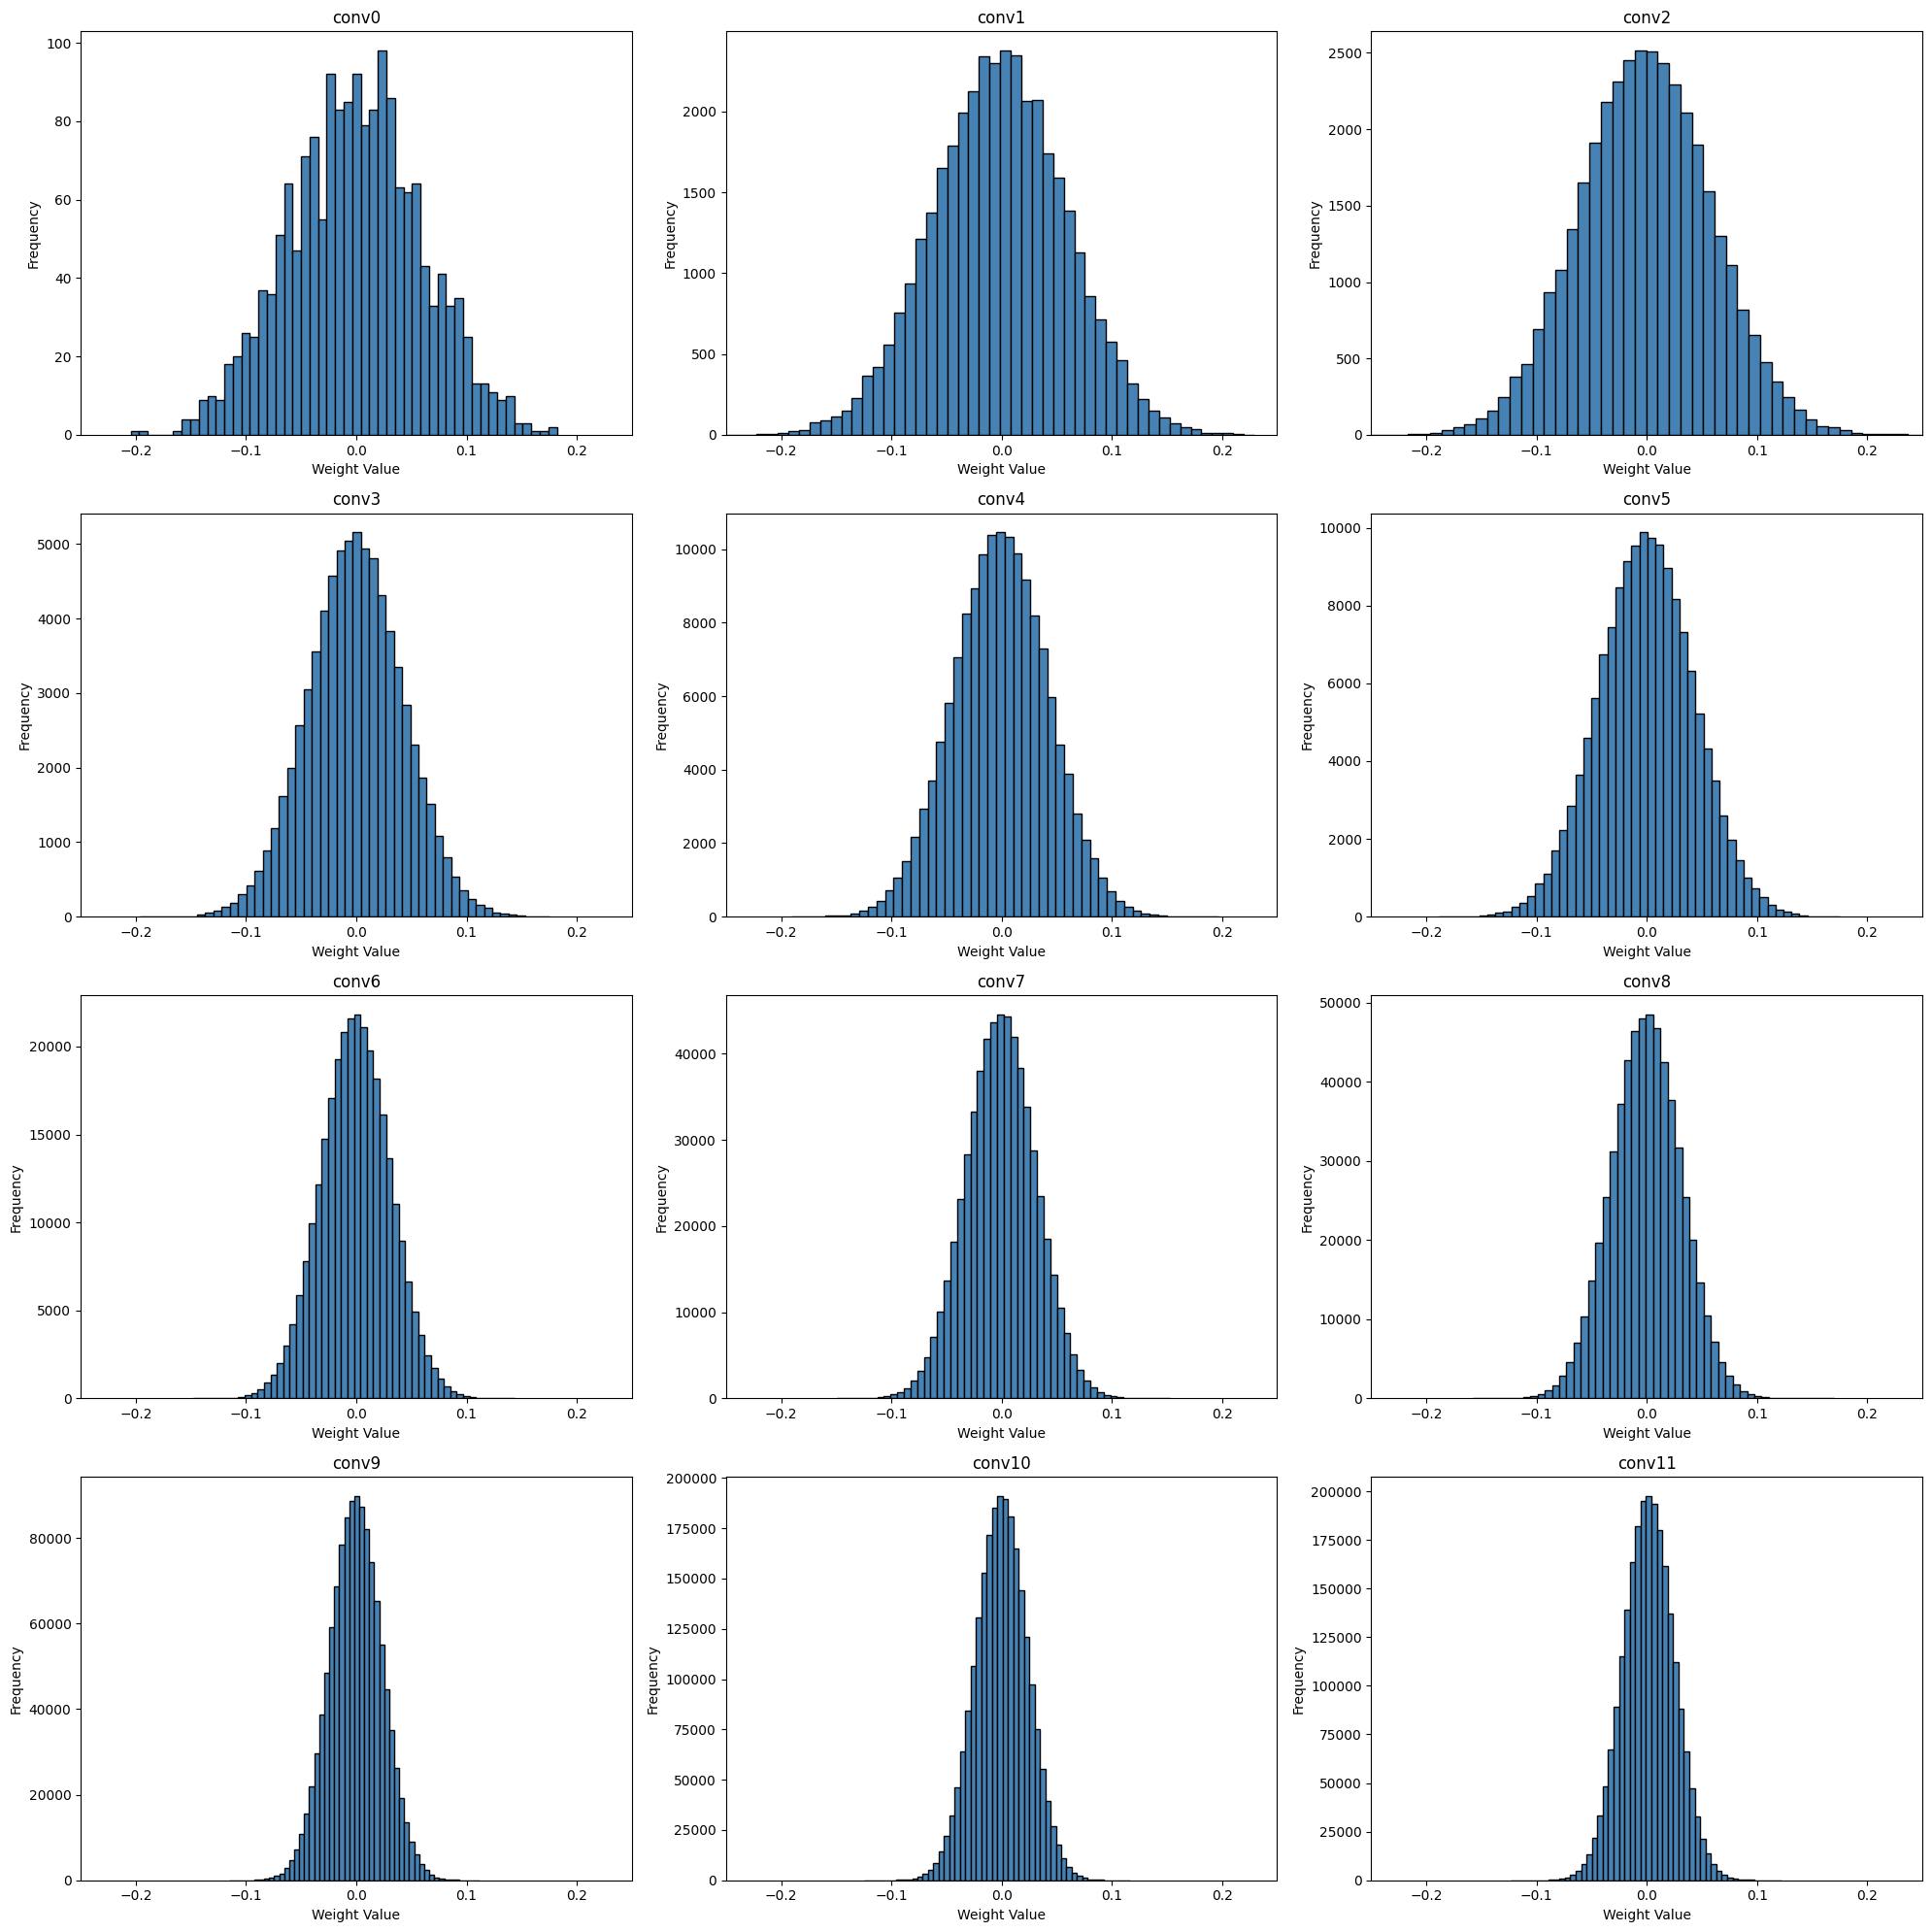

In [40]:
plot_weight_distribution(vgg16.features, x_lim=0.25, pruned=False)

## <a id='toc4_2_'></a>[Finegrained Pruning](#toc0_)

### <a id='toc4_2_1_'></a>[Post Pruning](#toc0_)

<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


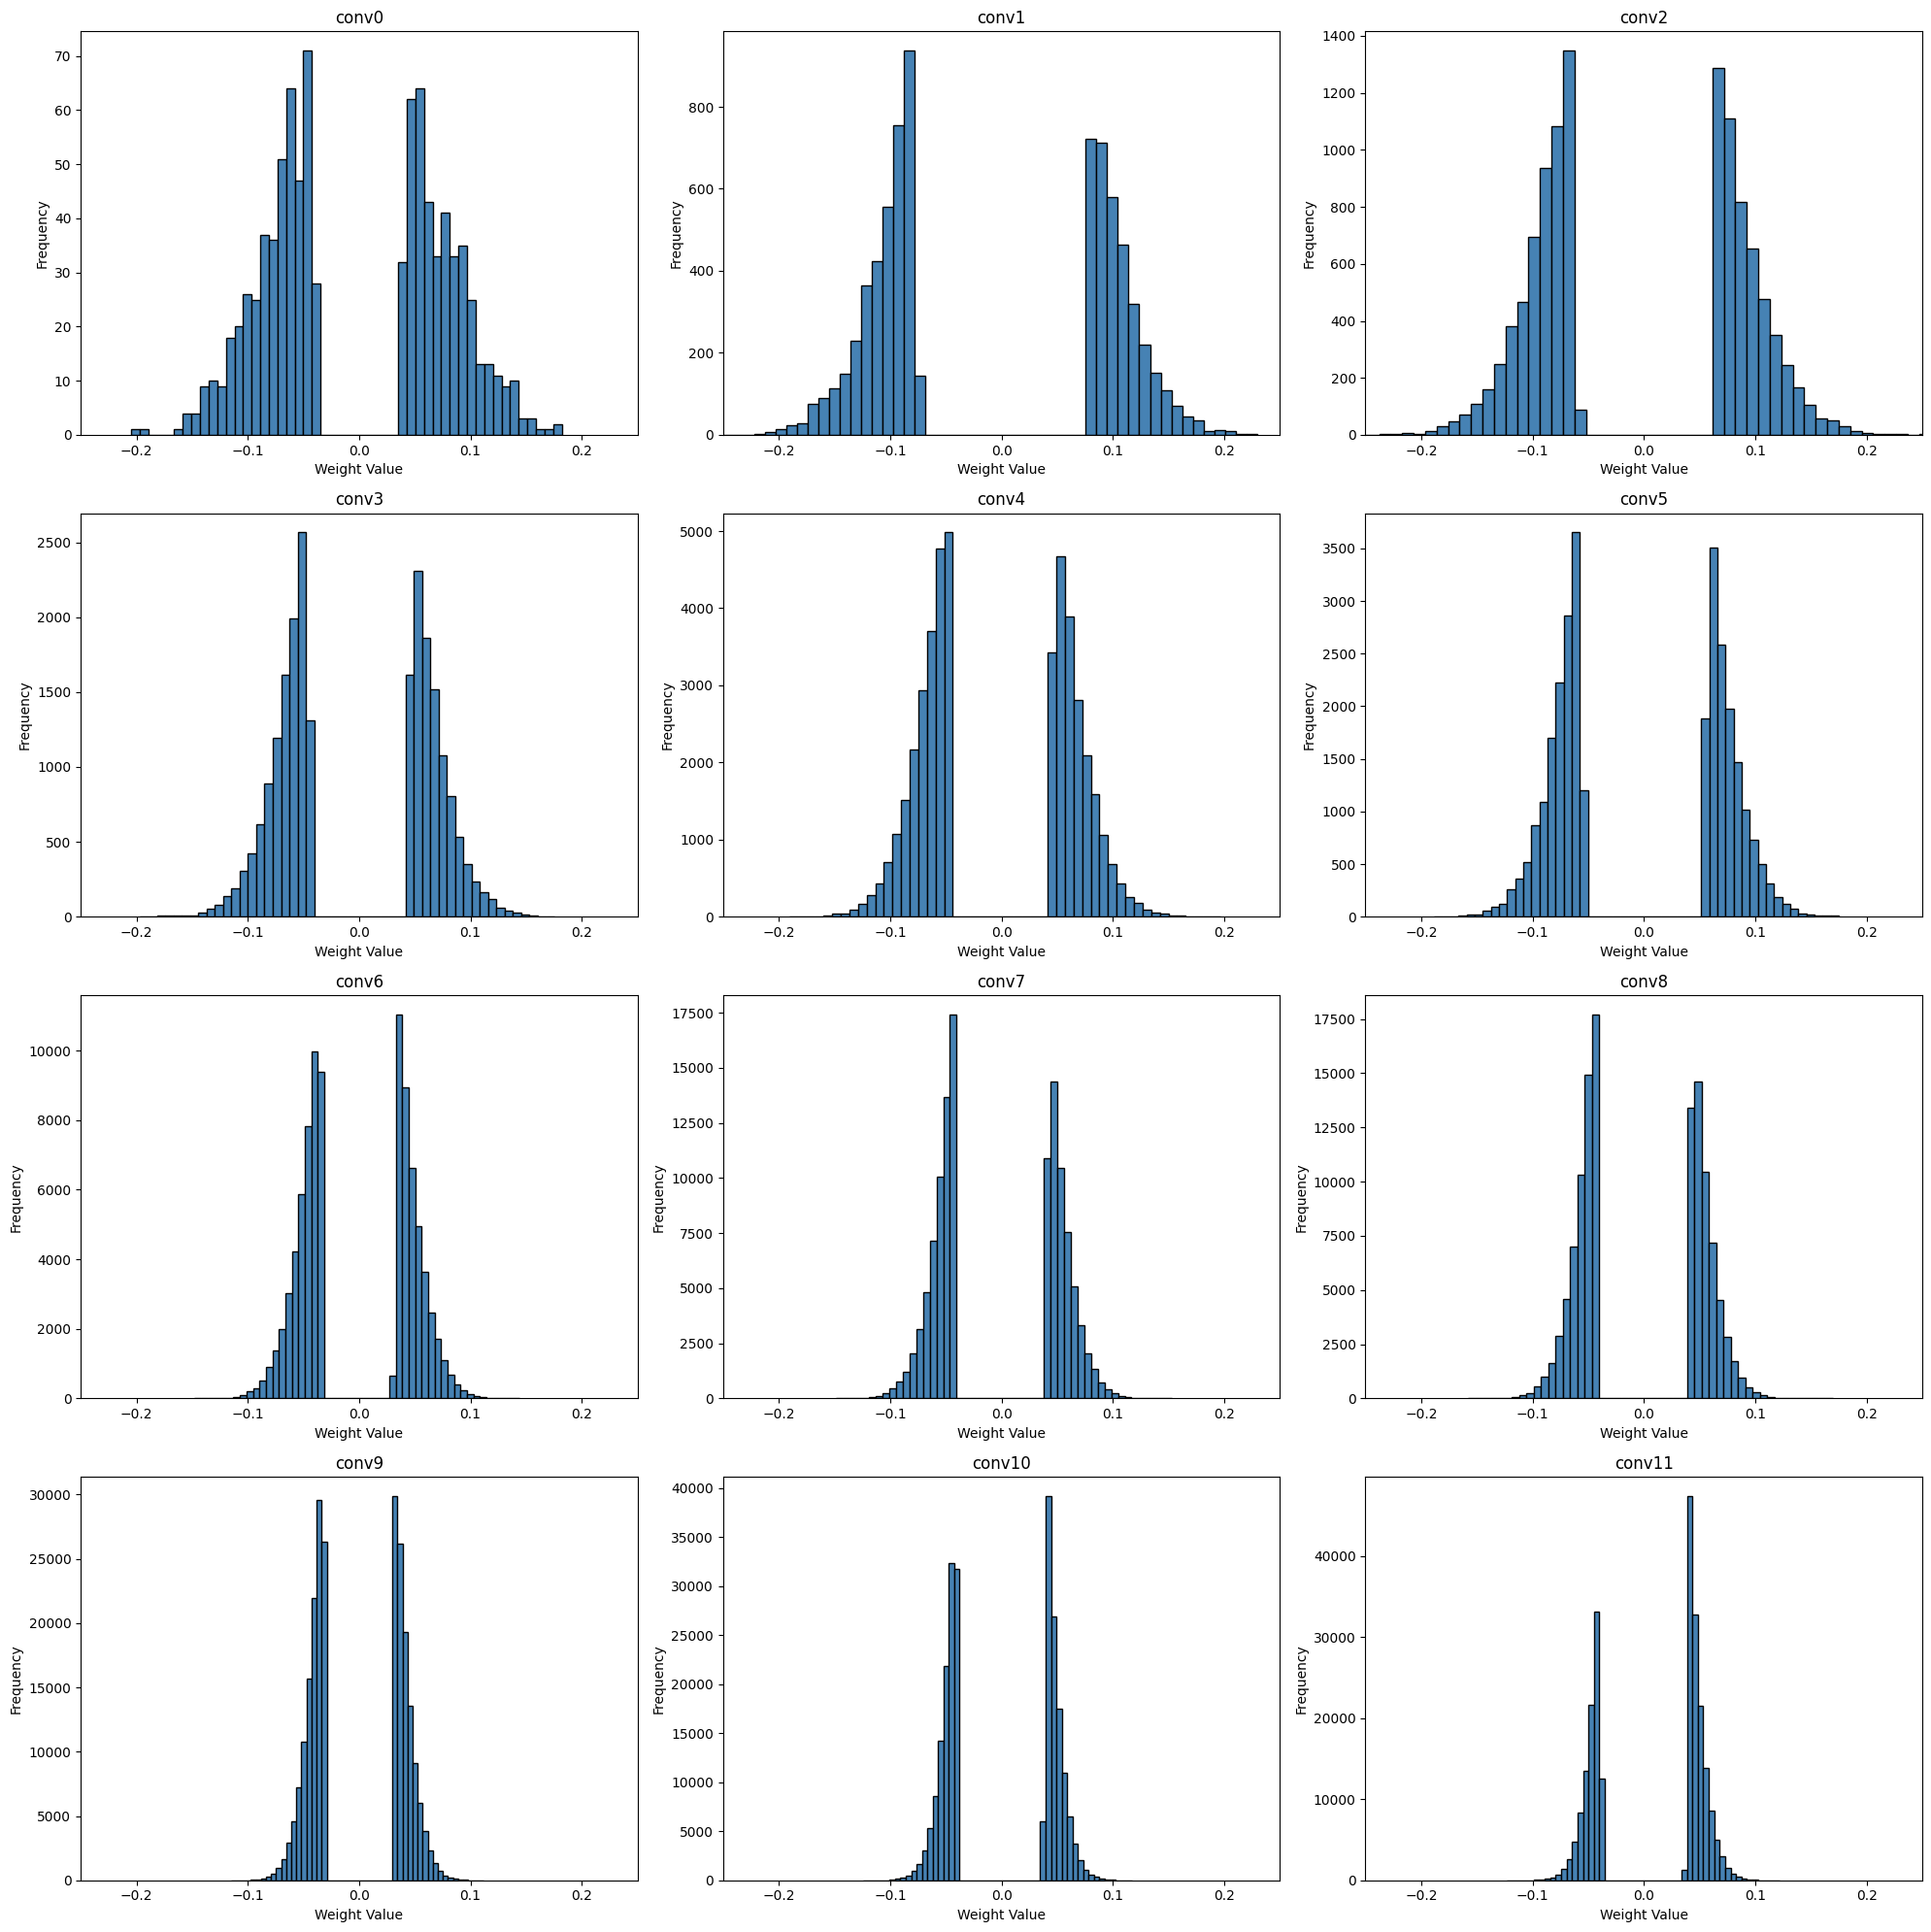

In [41]:
plot_weight_distribution(vgg16_finegrained_pp.features,x_lim=0.25,pruned=True)

### <a id='toc4_2_2_'></a>[Fine-tuning](#toc0_)

<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


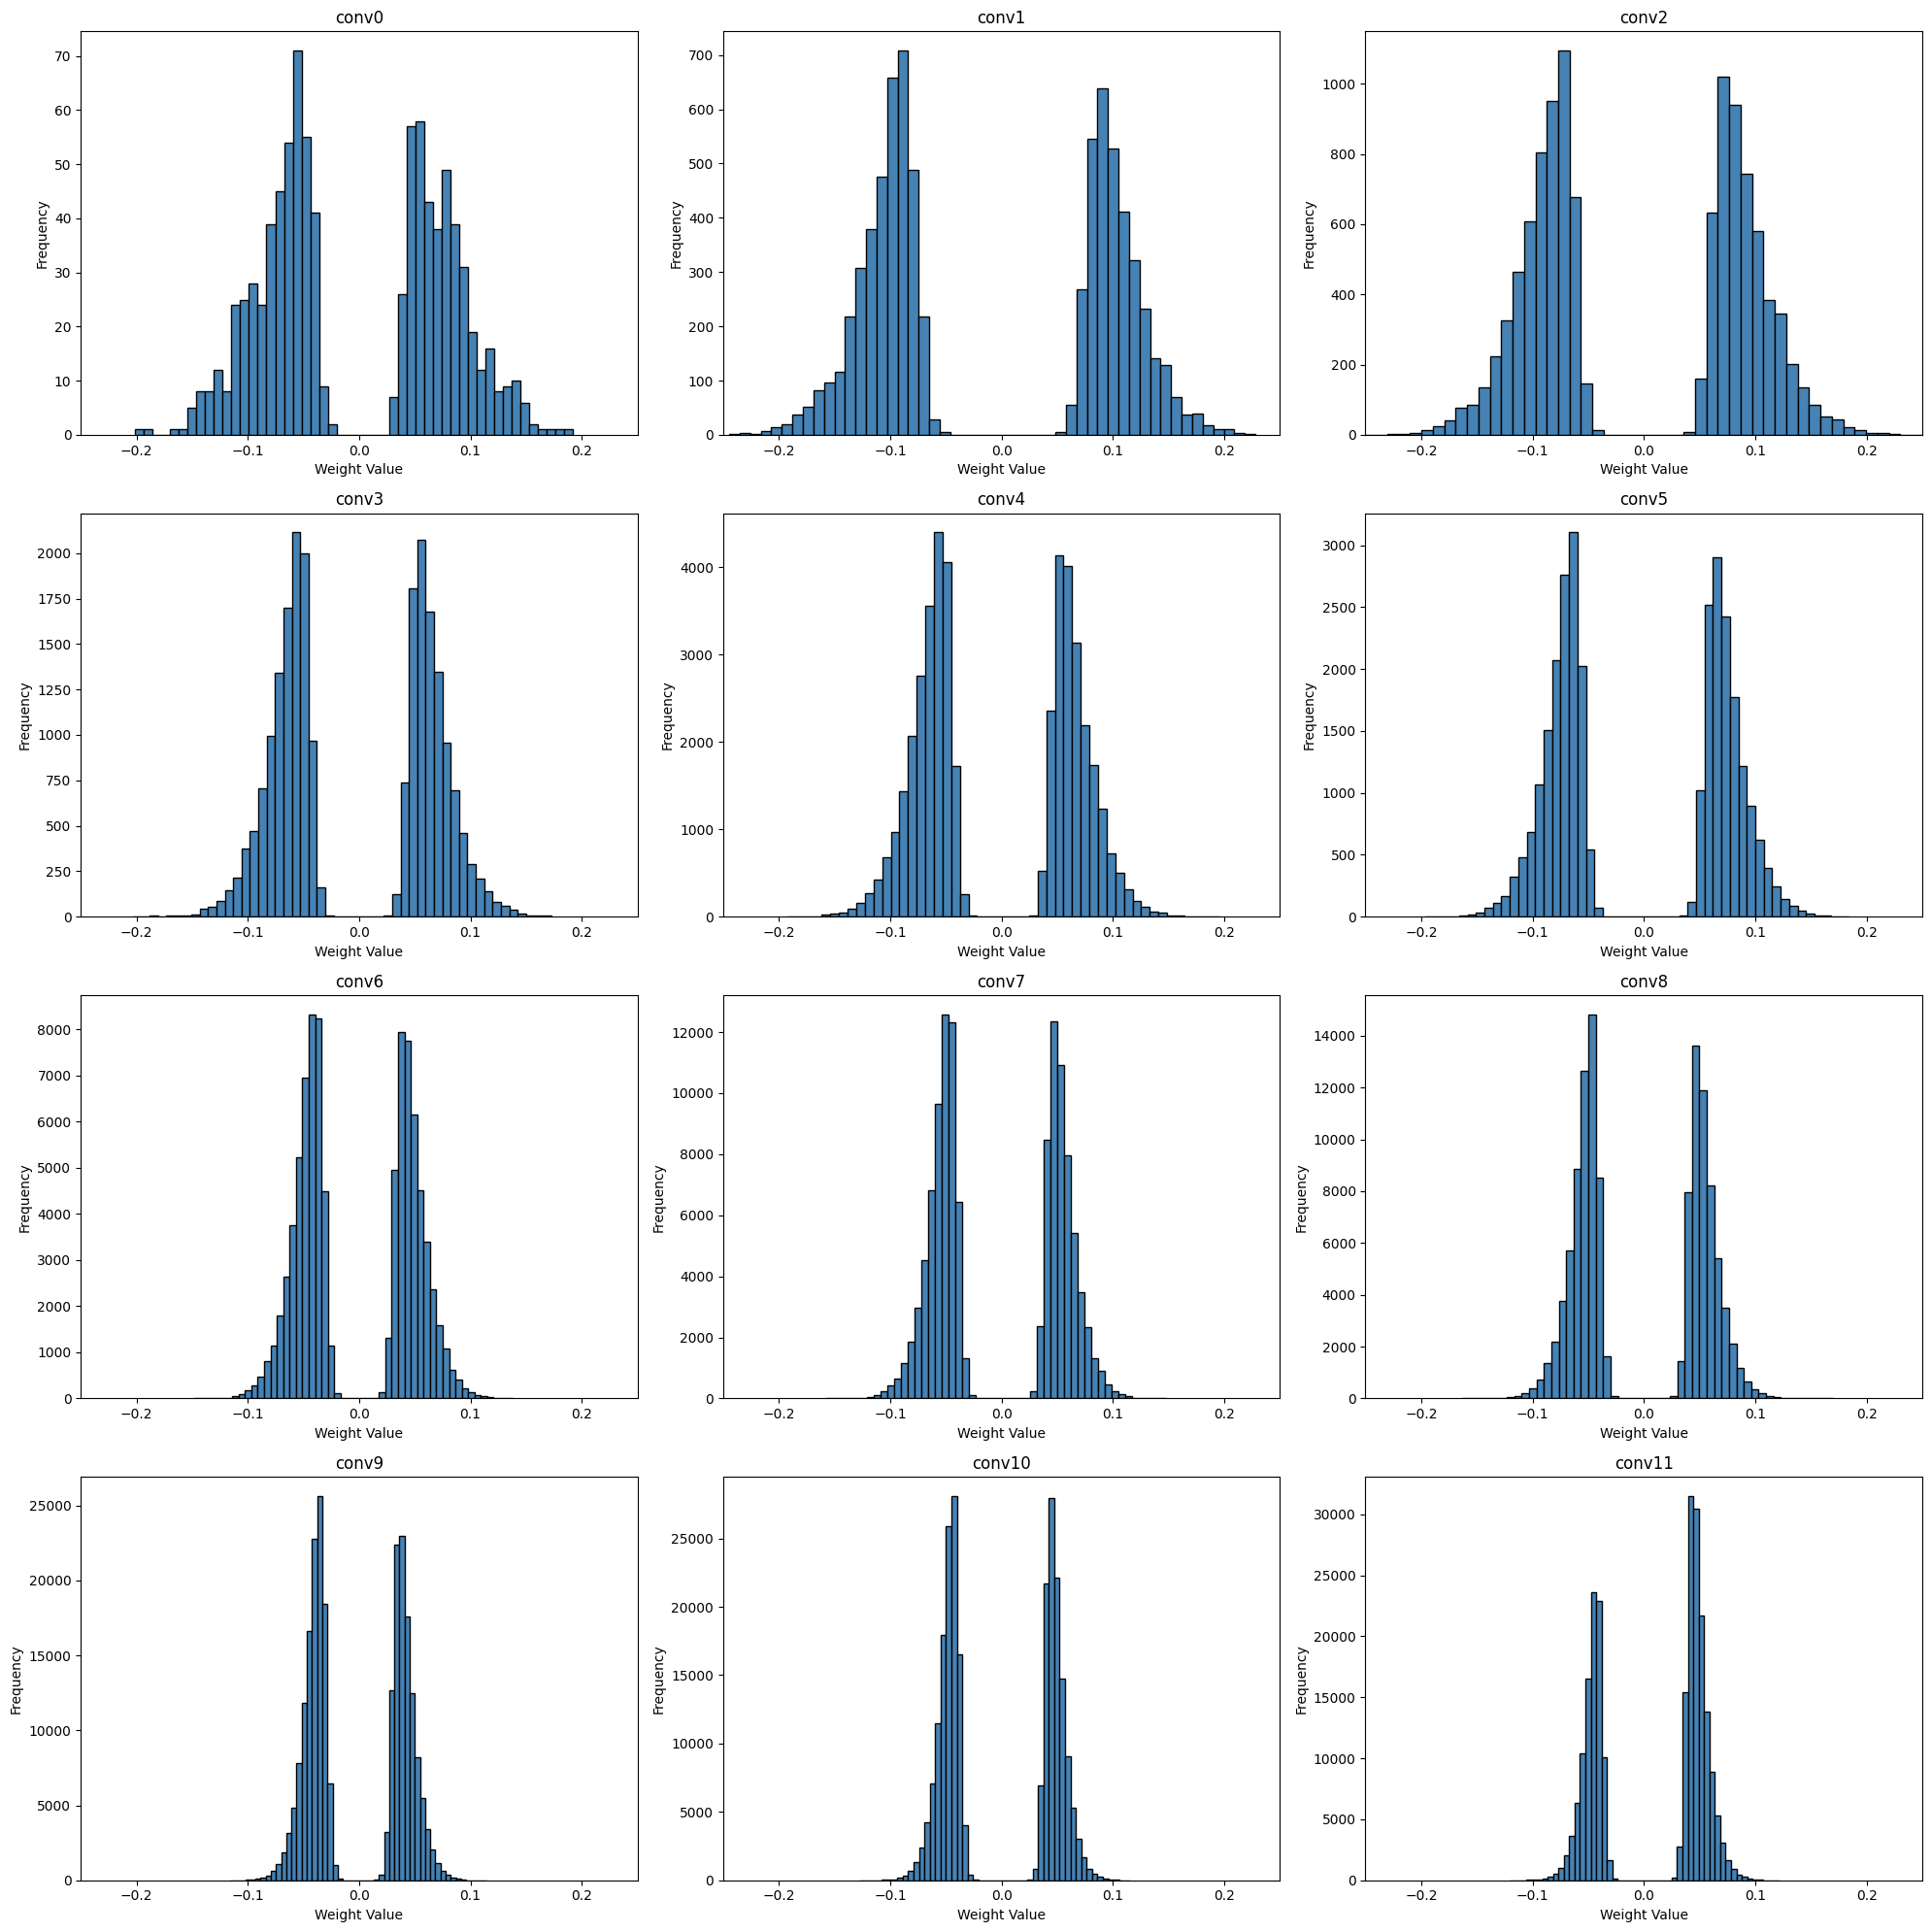

In [42]:
plot_weight_distribution(vgg16_finegrained.features,x_lim=0.25,pruned=True)

## <a id='toc4_3_'></a>[Kernel Pruning](#toc0_)

### <a id='toc4_3_1_'></a>[Post Pruning](#toc0_)

<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


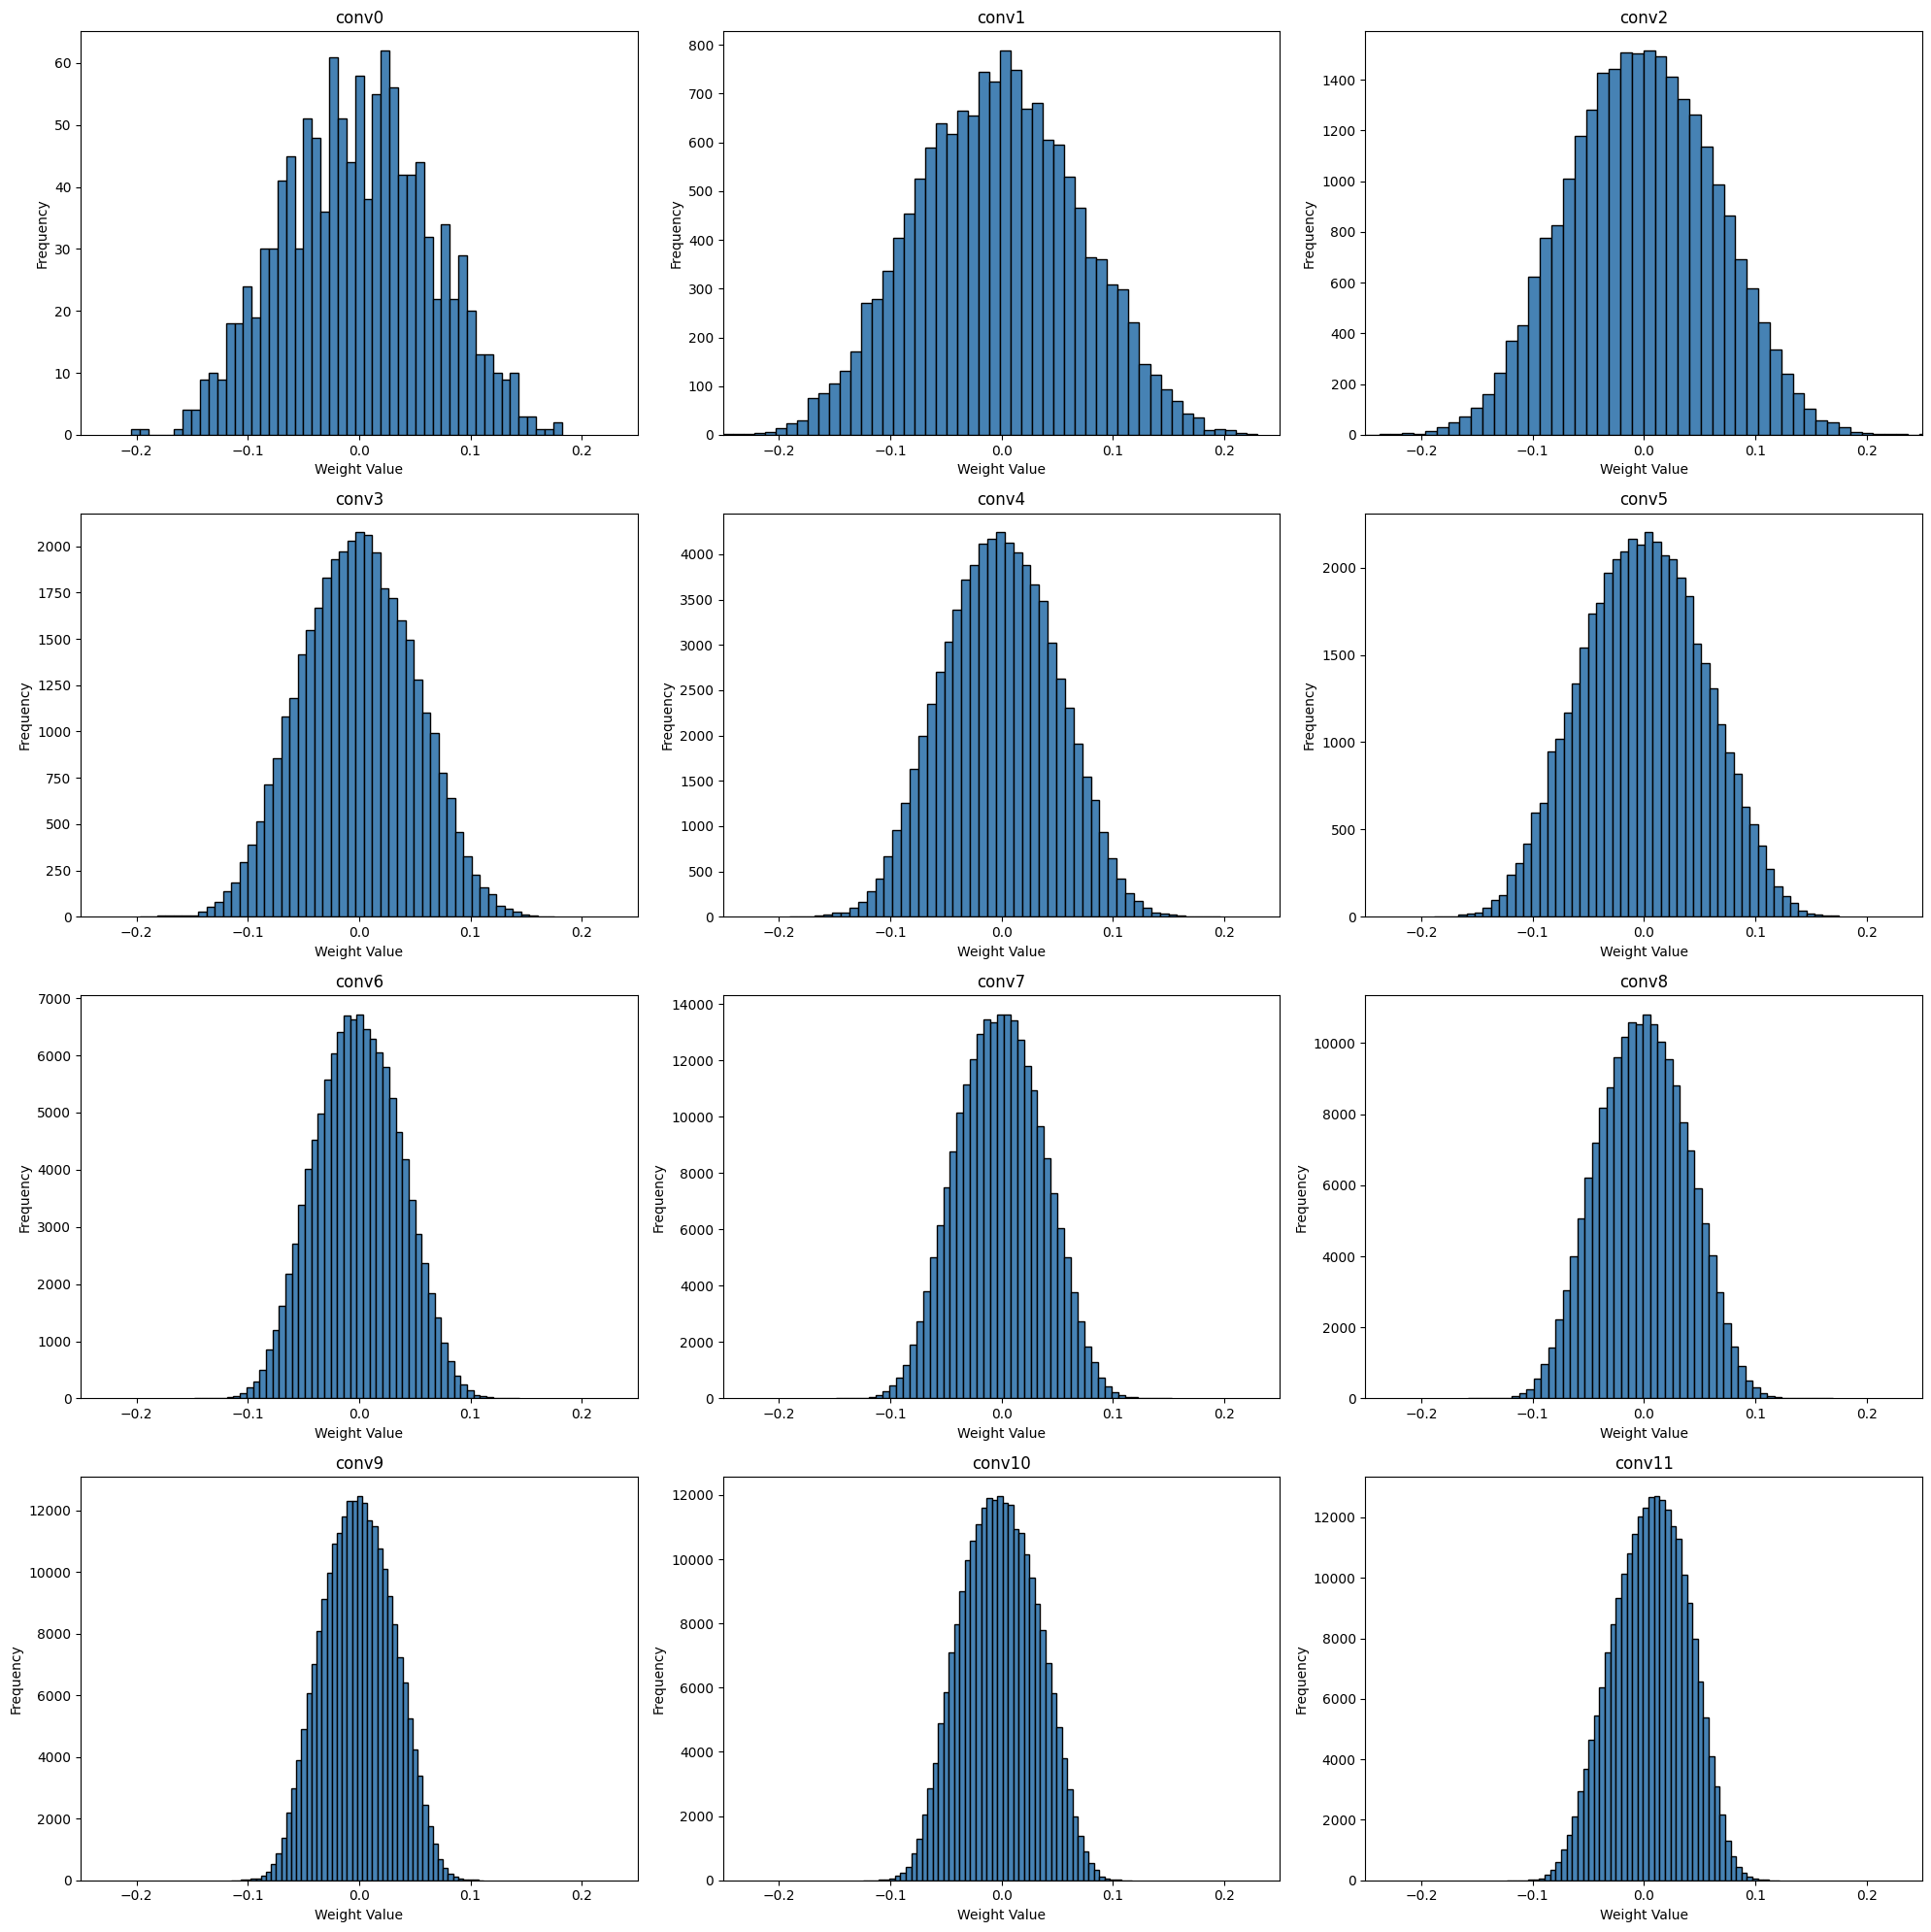

In [46]:
plot_weight_distribution(vgg16_kernel_pp.features,x_lim=0.25,pruned=True)

### <a id='toc4_3_2_'></a>[Fine-tuned](#toc0_)



<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


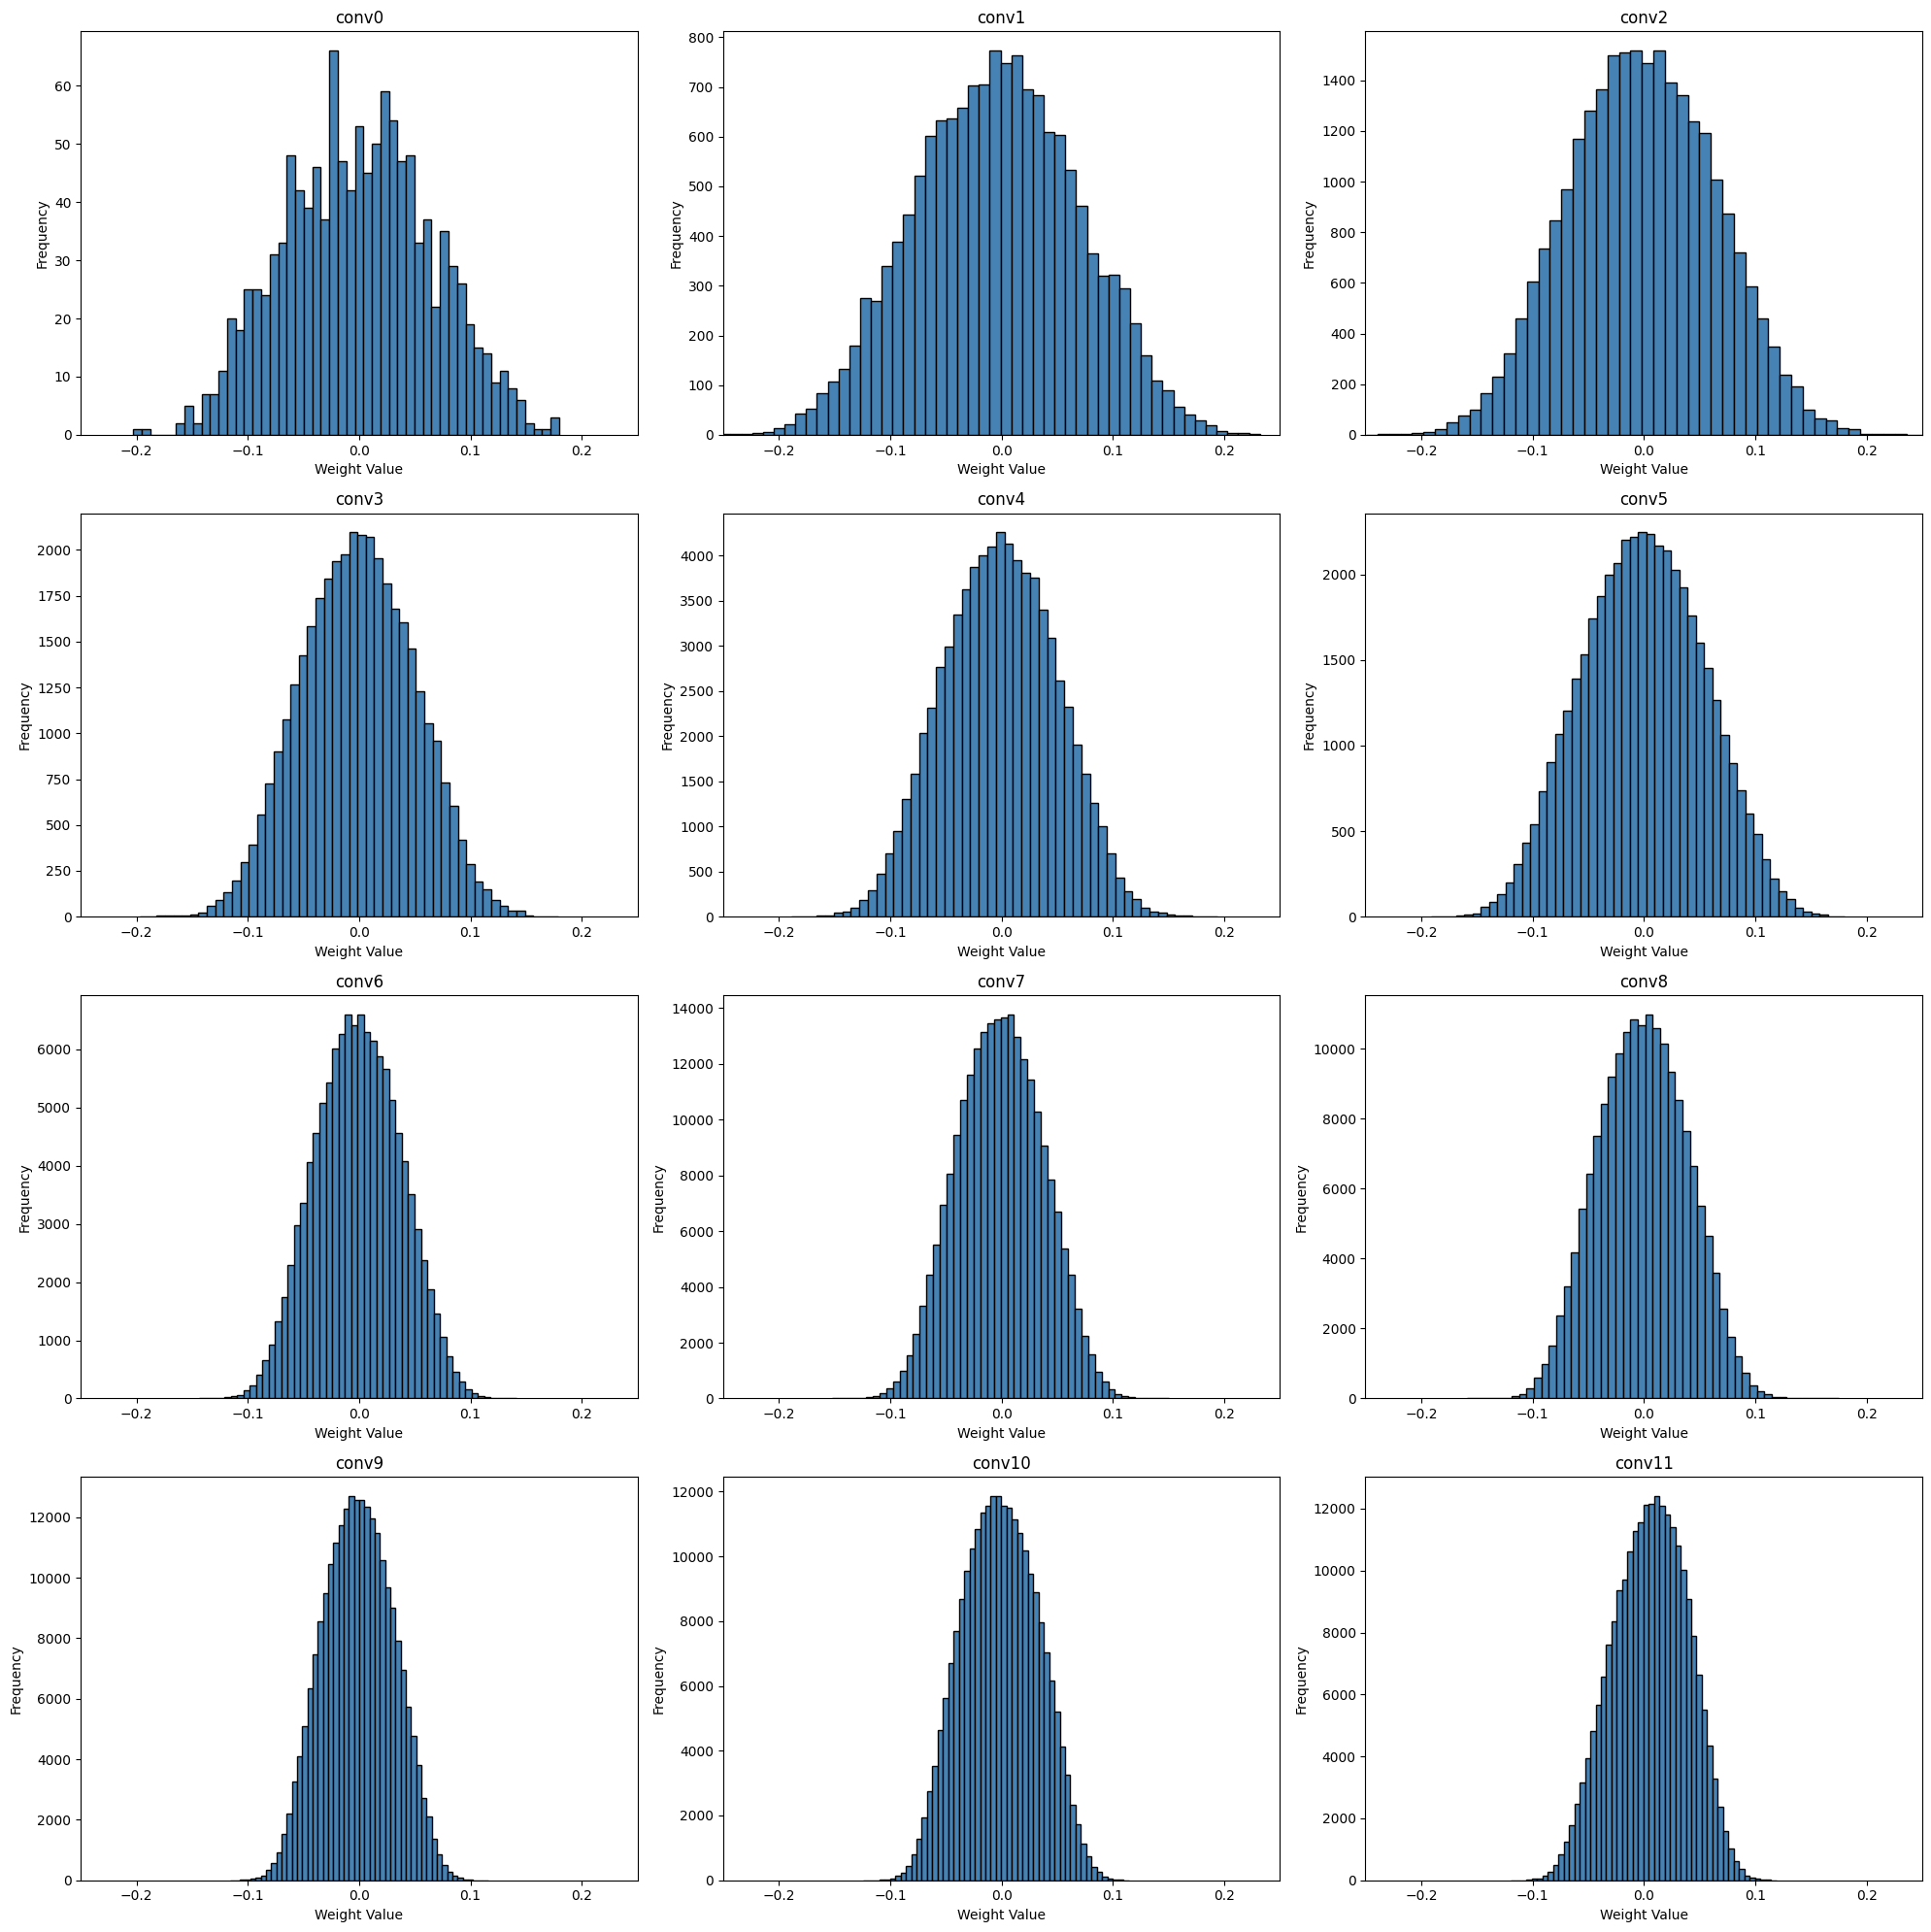

In [51]:
plot_weight_distribution(vgg16_kernel.features,x_lim=0.25,pruned=True)

## <a id='toc4_4_'></a>[Filter Pruning](#toc0_)

### <a id='toc4_4_1_'></a>[Post Pruning](#toc0_)

<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


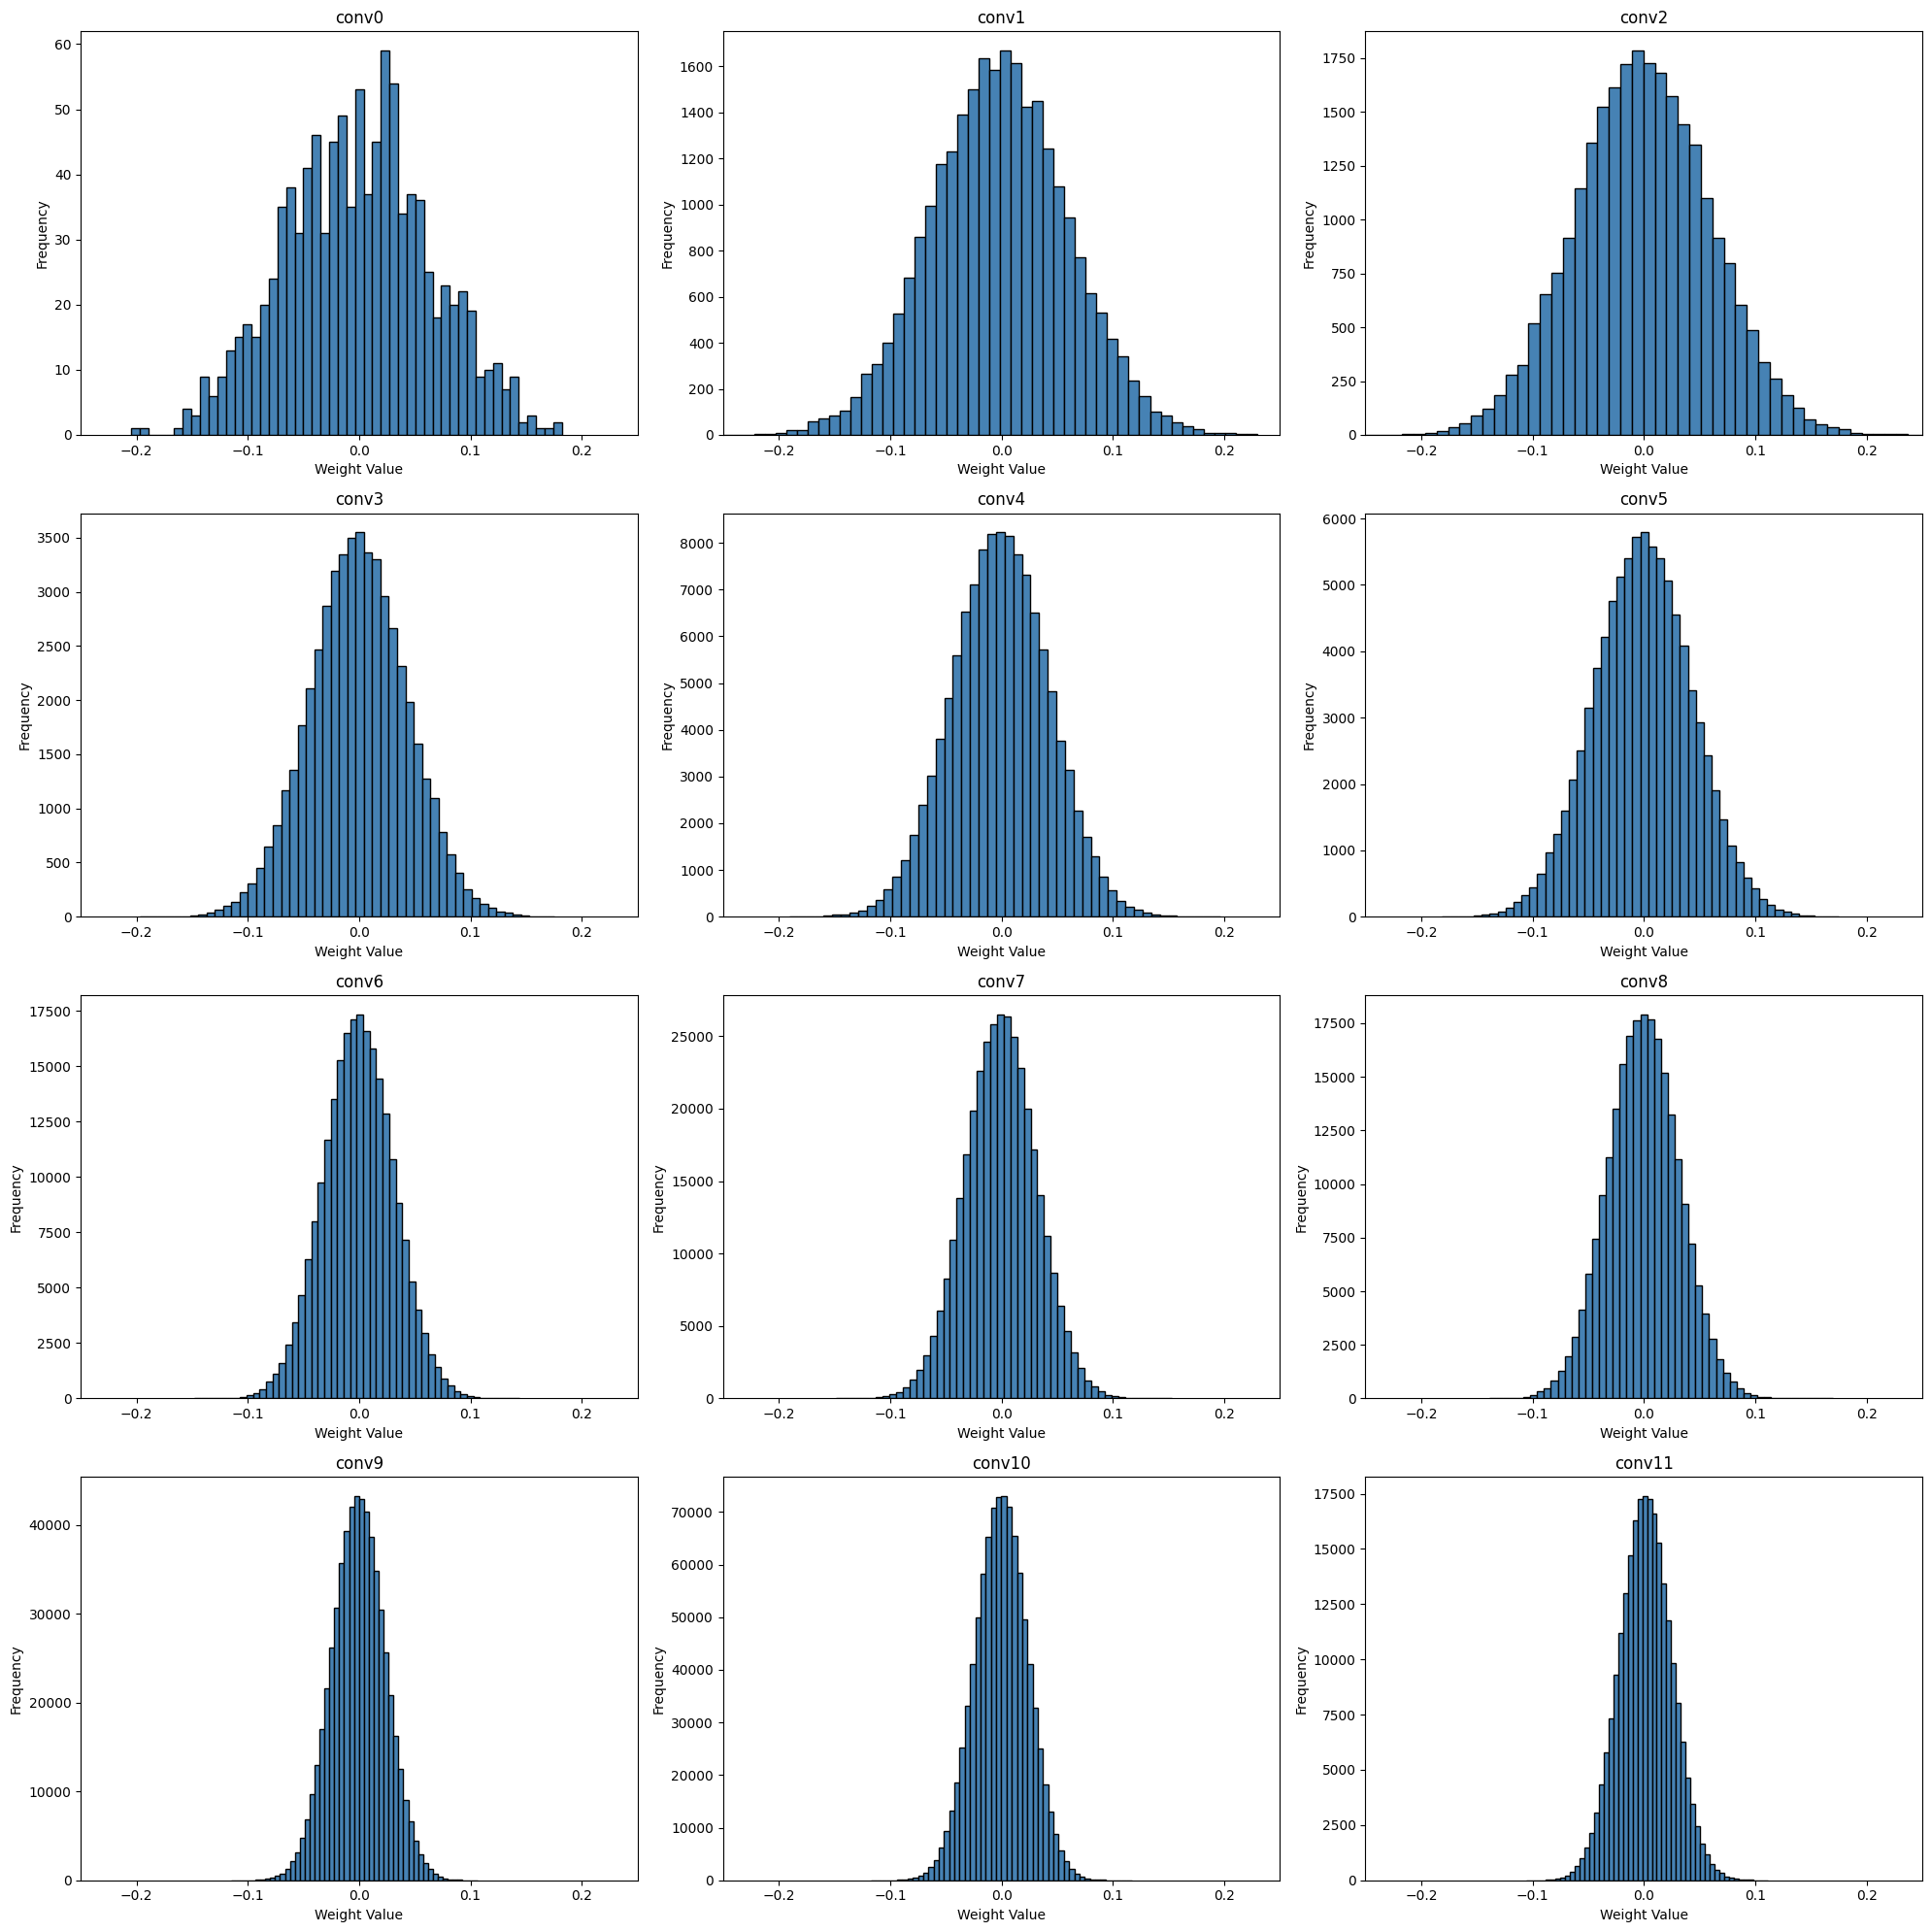

In [48]:
plot_weight_distribution(vgg16_filter_pp.features,x_lim=0.25,pruned=True)

### <a id='toc4_4_2_'></a>[Fine-tuned](#toc0_)



<ipython-input-39-f0ace1331a27>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


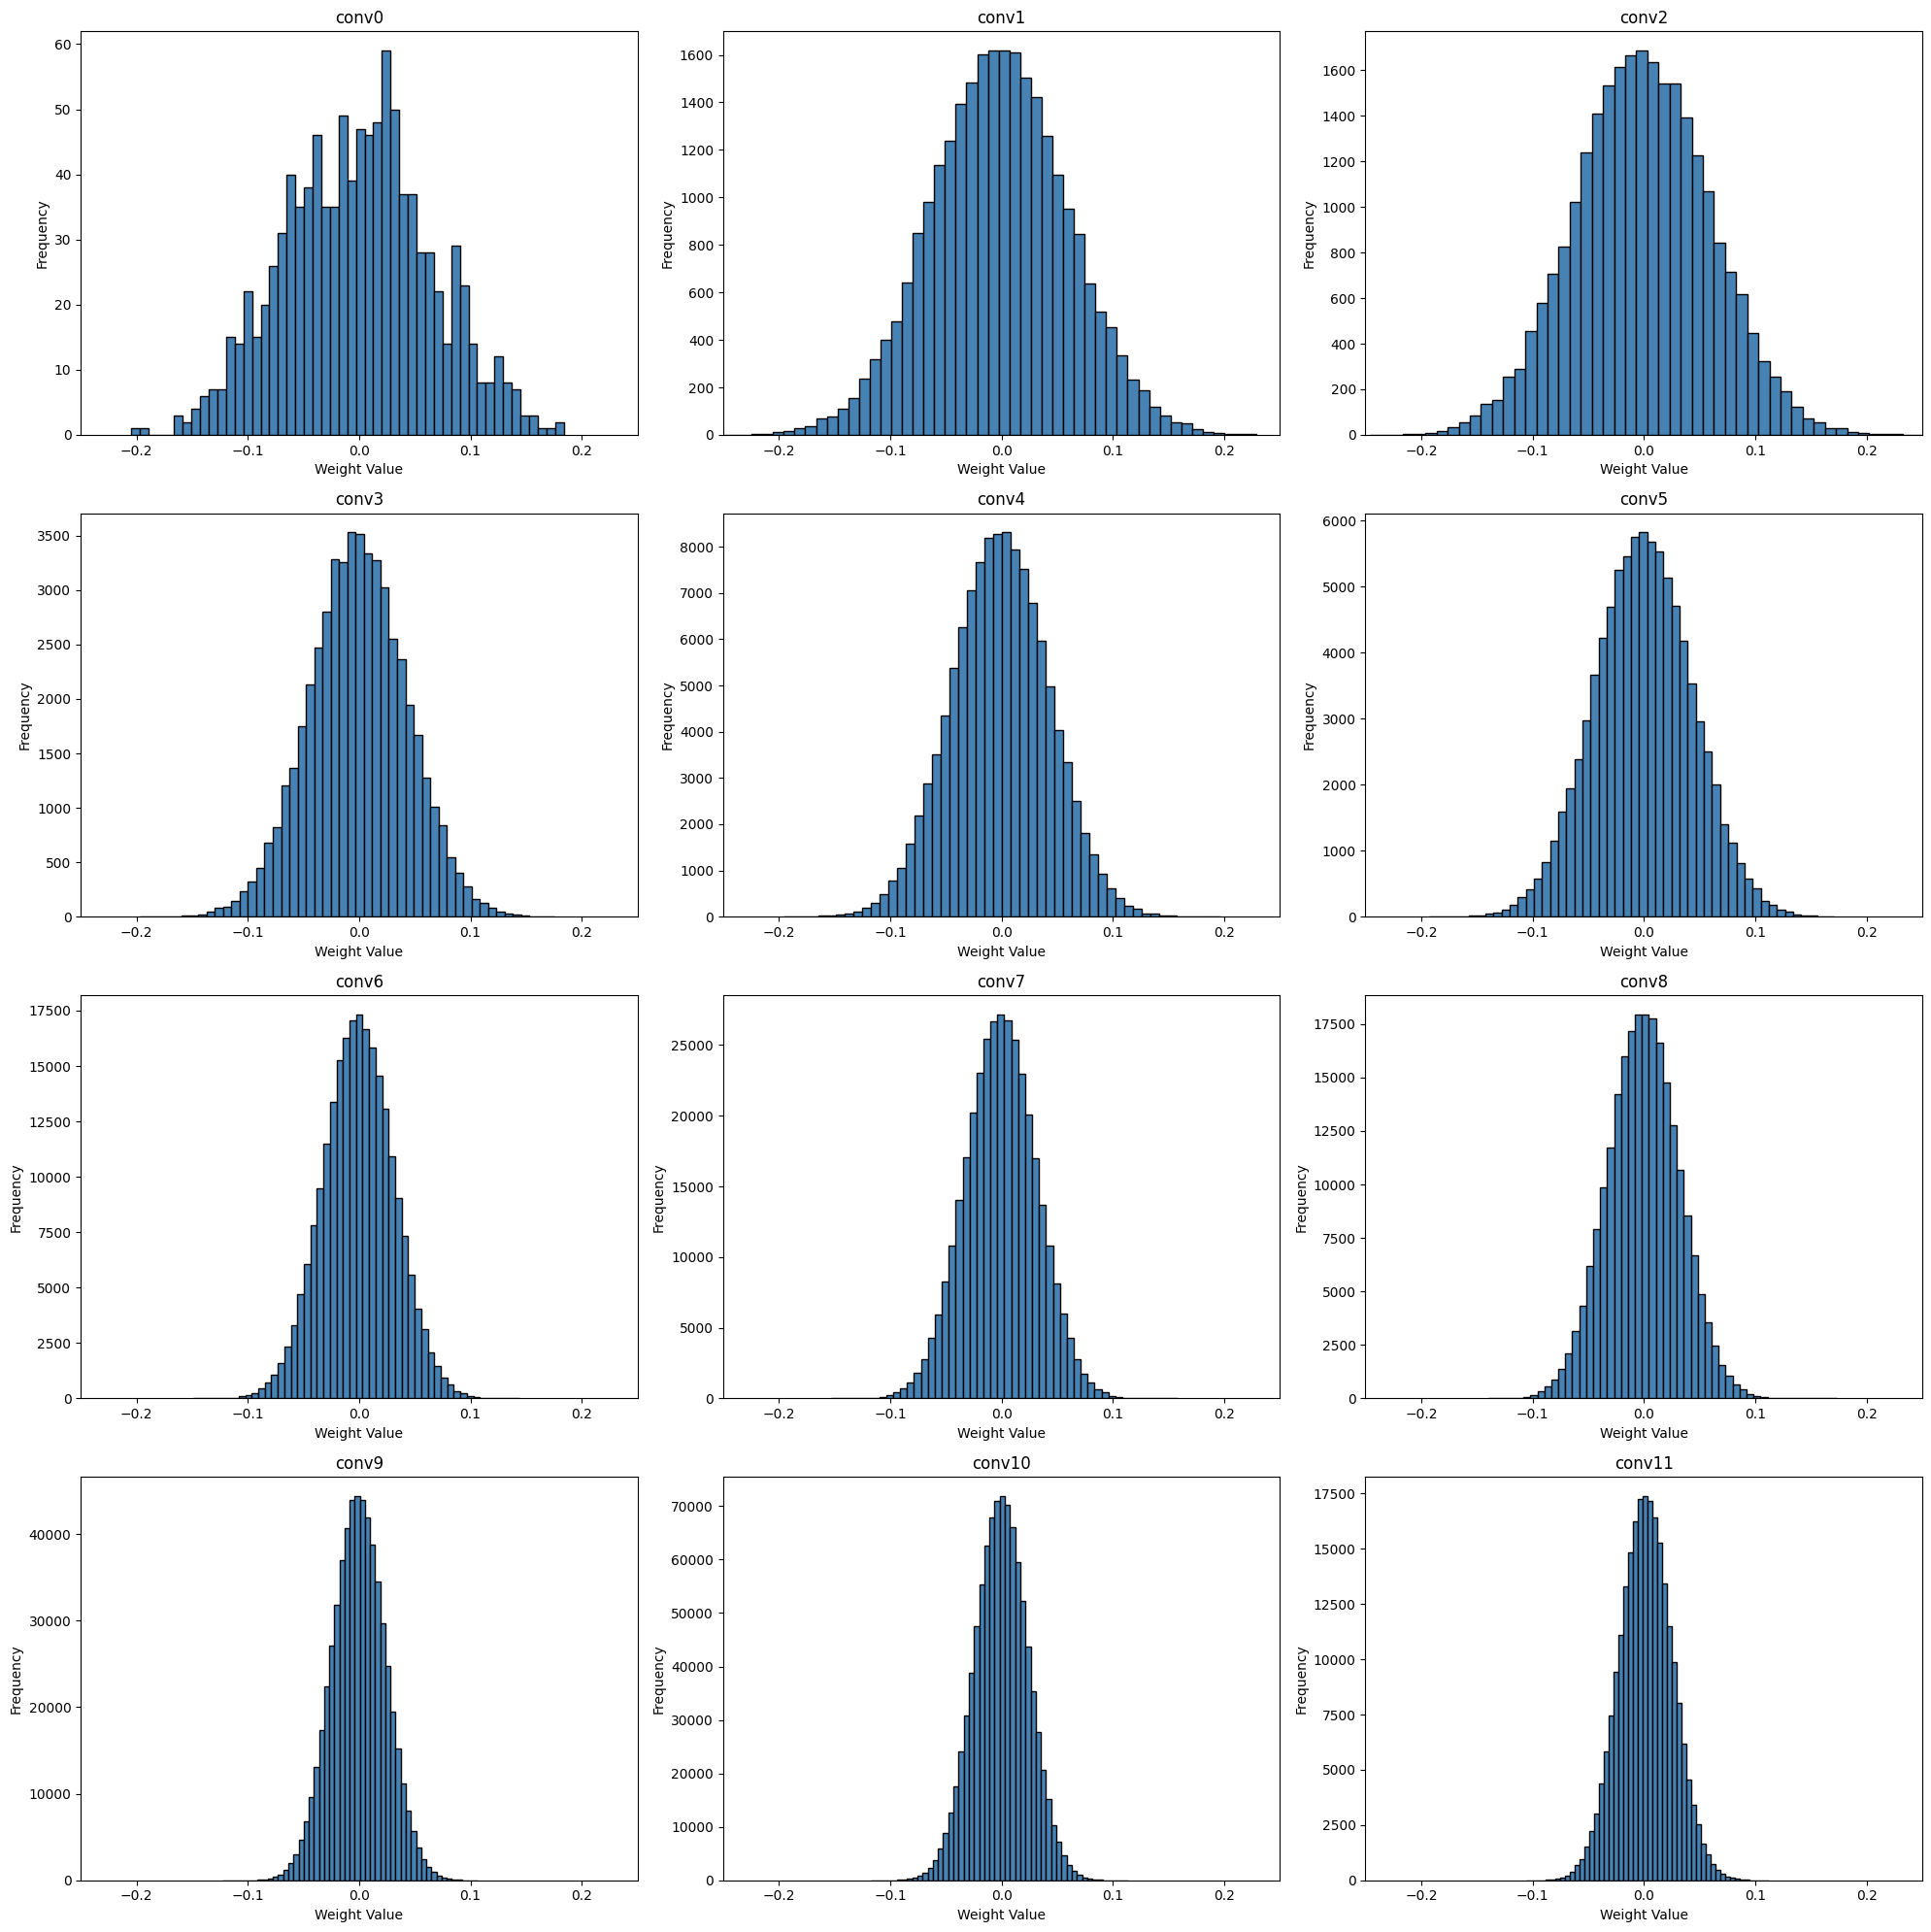

In [52]:
plot_weight_distribution(vgg16_filter.features,x_lim=0.25,pruned=True)

# <a id='toc5_'></a>[Accuracies of the Models](#toc0_)

In [33]:
def get_accuracy(model: nn.Module):
  total_correct = 0
  total_samples = 0
  with torch.no_grad():
    for inputs,labels in dataloader['test']:
      inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += inputs.size(0)
  return total_correct / total_samples

def fraction_remaining(pruned_model: nn.Module):
  return (utils.get_num_parameters(pruned_model, count_nonzero_only=True)/utils.get_num_parameters(vgg16, count_nonzero_only=True)).item()

In [39]:
print(f'Unpruned VGG-16 accuracy: {get_accuracy(vgg16)*100:.4f}%')


Unpruned VGG-16 accuracy: 85.0300%


In [40]:
print(f'Percentage of parameters remaining after fine-grained pruning: {fraction_remaining(vgg16_finegrained)*100:.4f}%')
print(f'VGG-16 accuracy after fine-grained pruning: {get_accuracy(vgg16_finegrained_pp)*100:.4f}%')
print(f'VGG-16 accuracy after finetuning pruned model: {get_accuracy(vgg16_finegrained)*100:.4f}%')


Percentage of parameters remaining after fine-grained pruning: 20.4959%
VGG-16 accuracy after fine-grained pruning: 40.8100%
VGG-16 accuracy after finetuning pruned model: 82.6900%


In [41]:
print(f'Percentage of parameters remaining after kernel pruning: {fraction_remaining(vgg16_kernel)*100:.4f}%')
print(f'VGG-16 accuracy after kernel pruning: {get_accuracy(vgg16_kernel_pp)*100:.4f}%')
print(f'VGG-16 accuracy after finetuning pruned model: {get_accuracy(vgg16_kernel)*100:.4f}%')

Percentage of parameters remaining after kernel pruning: 23.9542%
VGG-16 accuracy after kernel pruning: 17.9400%
VGG-16 accuracy after finetuning pruned model: 80.7000%


In [42]:
print(f'Percentage of parameters remaining after filter pruning: {fraction_remaining(vgg16_filter)*100:.4f}%')
print(f'VGG-16 accuracy after filter pruning: {get_accuracy(vgg16_filter_pp)*100:.4f}%')
print(f'VGG-16 accuracy after finetuning pruned model: {get_accuracy(vgg16_filter)*100:.4f}%')

Percentage of parameters remaining after filter pruning: 41.4917%
VGG-16 accuracy after filter pruning: 14.0500%
VGG-16 accuracy after finetuning pruned model: 82.4400%


# <a id='toc6_'></a>[Activations](#toc0_)

In [15]:

def plot_activation_distribution(module: nn.Module,
                                 input_tensor: torch.Tensor,
                                 layer_names: list[str] = LAYER_NAMES,
                                 num_columns: int = 3):
    """
    Plots the activation distribution for specified layers in the model after passing the given input tensor.

    Args:
    module (torch.nn.Module): The module being analyzed.
    layer_names (list of str): Names of the layers whose activations should be plotted.
    input_tensor (torch.Tensor): The input tensor to feed into the module to obtain activations.
    num_columns (int): Number of columns in the subplot grid.
    """
    activations = {}

    # Define a hook to capture the activations from the layers during the forward pass
    def get_activation(name):
        def hook(module, input, output):
            activations[name] = torch.squeeze(output).detach()
        return hook

    # Attach the hooks to the layers.
    hooks = []
    for layer in layer_names:
          hook = module._modules[layer].register_forward_hook(get_activation(layer))
          hooks.append(hook)

    # Perform a forward pass to get the activations
    module(torch.unsqueeze(input_tensor,0).to(DEVICE))

    # Remove the hooks
    for hook in hooks:
        hook.remove()

    # Calculate the number of rows needed for the subplots
    num_rows = (len(layer_names) + num_columns - 1) // 3

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 3 * num_rows))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    # Plot the activation distributions
    for idx, layer_name in enumerate(layer_names):
        layer_activations = activations[layer_name].cpu().numpy()
        # Flatten the activations to 2D for histogram plotting
        layer_activations = layer_activations.flatten()
        layer_activations = layer_activations[layer_activations != 0]
        ax = axes[idx]
        ax.hist(layer_activations, bins=50, color='orange', edgecolor='black')
        ax.set_title(f'{layer_name}')
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Frequency')
        ax.set_xlim([-5, 5])

    plt.tight_layout()
    plt.show()


def show_image(tensor):
    """
    Displays an image given a PyTorch tensor.

    Args:
    tensor (torch.Tensor): The image tensor to display. Expected shape [C, H, W].
    """
    # Check if the tensor has the channel as the first dimension
    if tensor.size(0) == 3:
        # Convert it to [H, W, C] for displaying purposes
        tensor = tensor.permute(1, 2, 0)
    plt.figure(figsize=(8, 8))
    plt.imshow(tensor.numpy())
    plt.axis('off')  # Hide the axis ticks and labels
    plt.show()

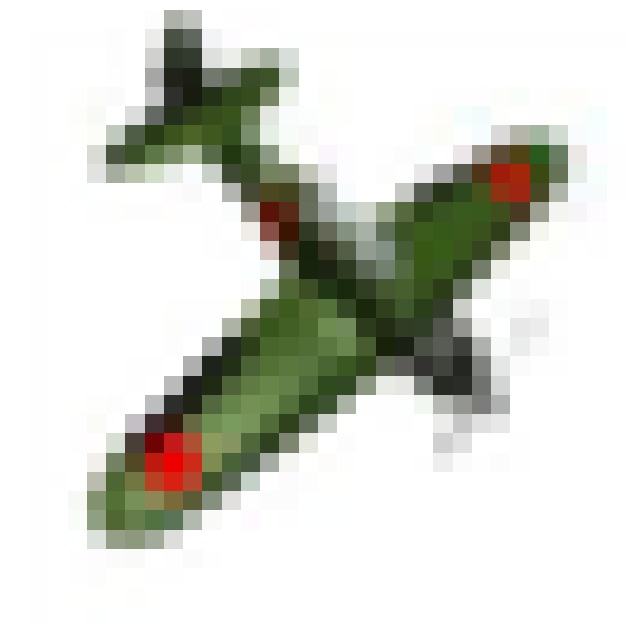

In [16]:
index = 98
tensor_image = dataset['test'][index][0]
show_image(tensor_image)

## <a id='toc6_1_'></a>[Unpruned](#toc0_)


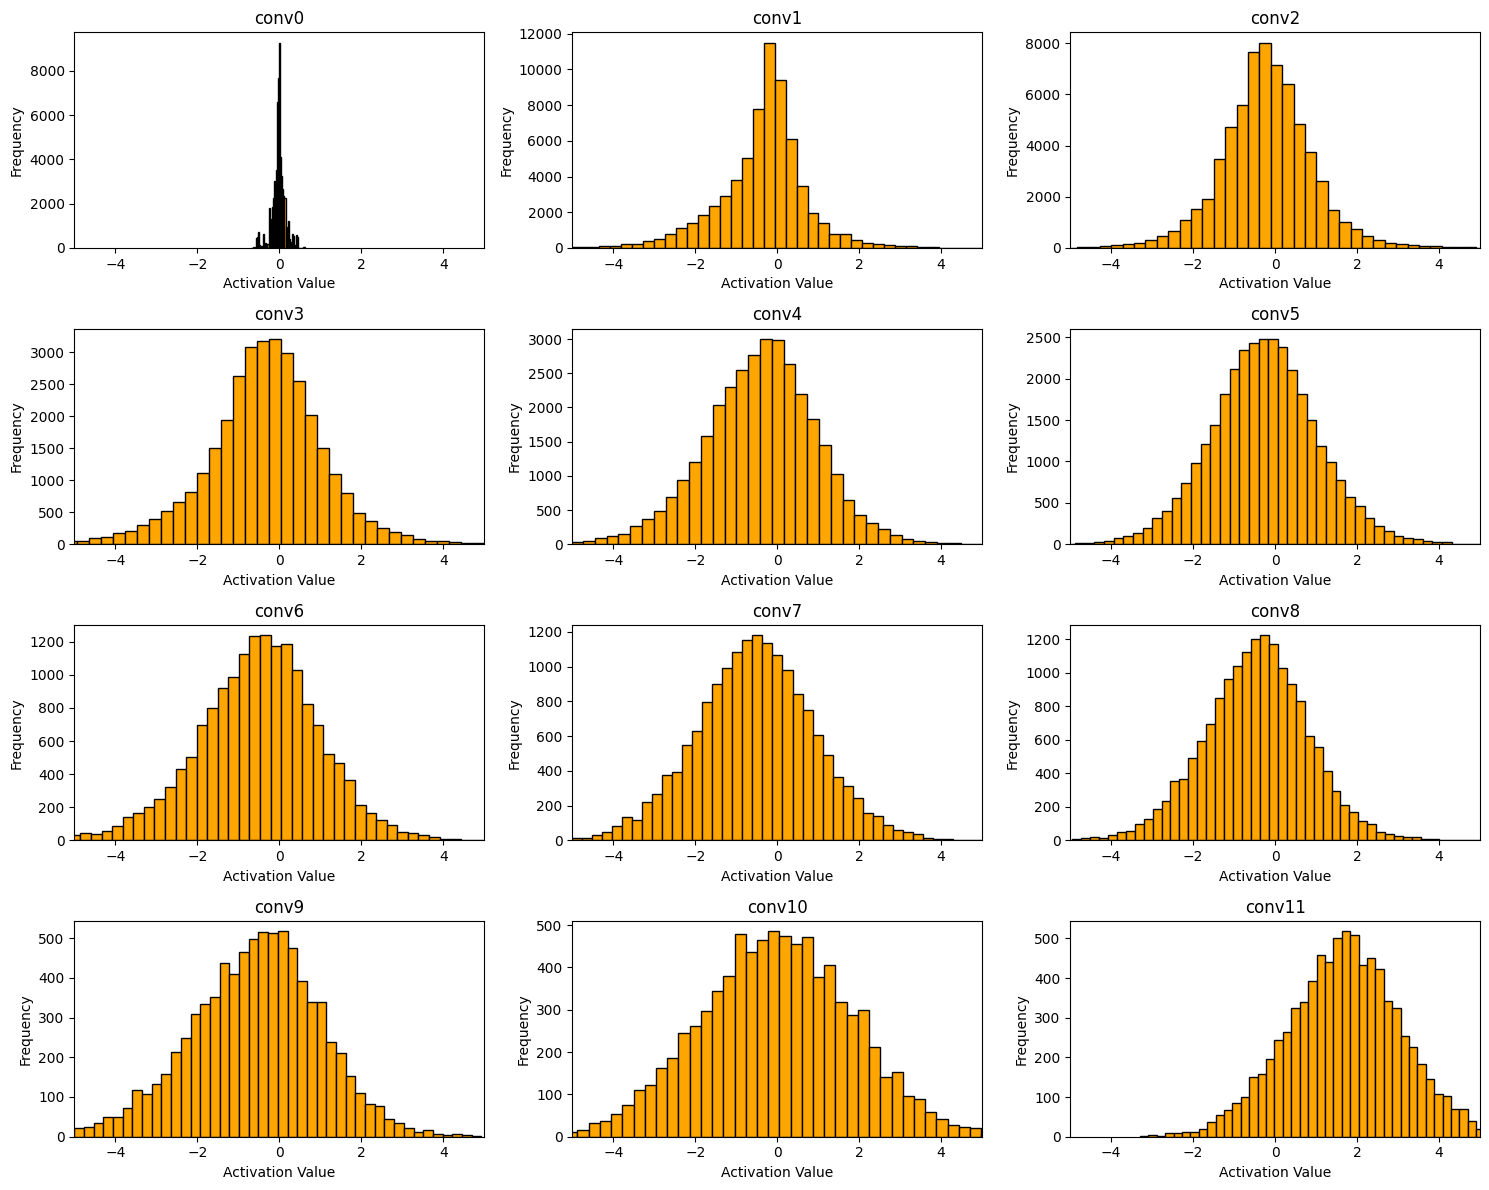

In [17]:
plot_activation_distribution(vgg16.features,tensor_image)

## <a id='toc6_2_'></a>[Finegrained](#toc0_)

### <a id='toc6_2_1_'></a>[Post-Pruning](#toc0_)

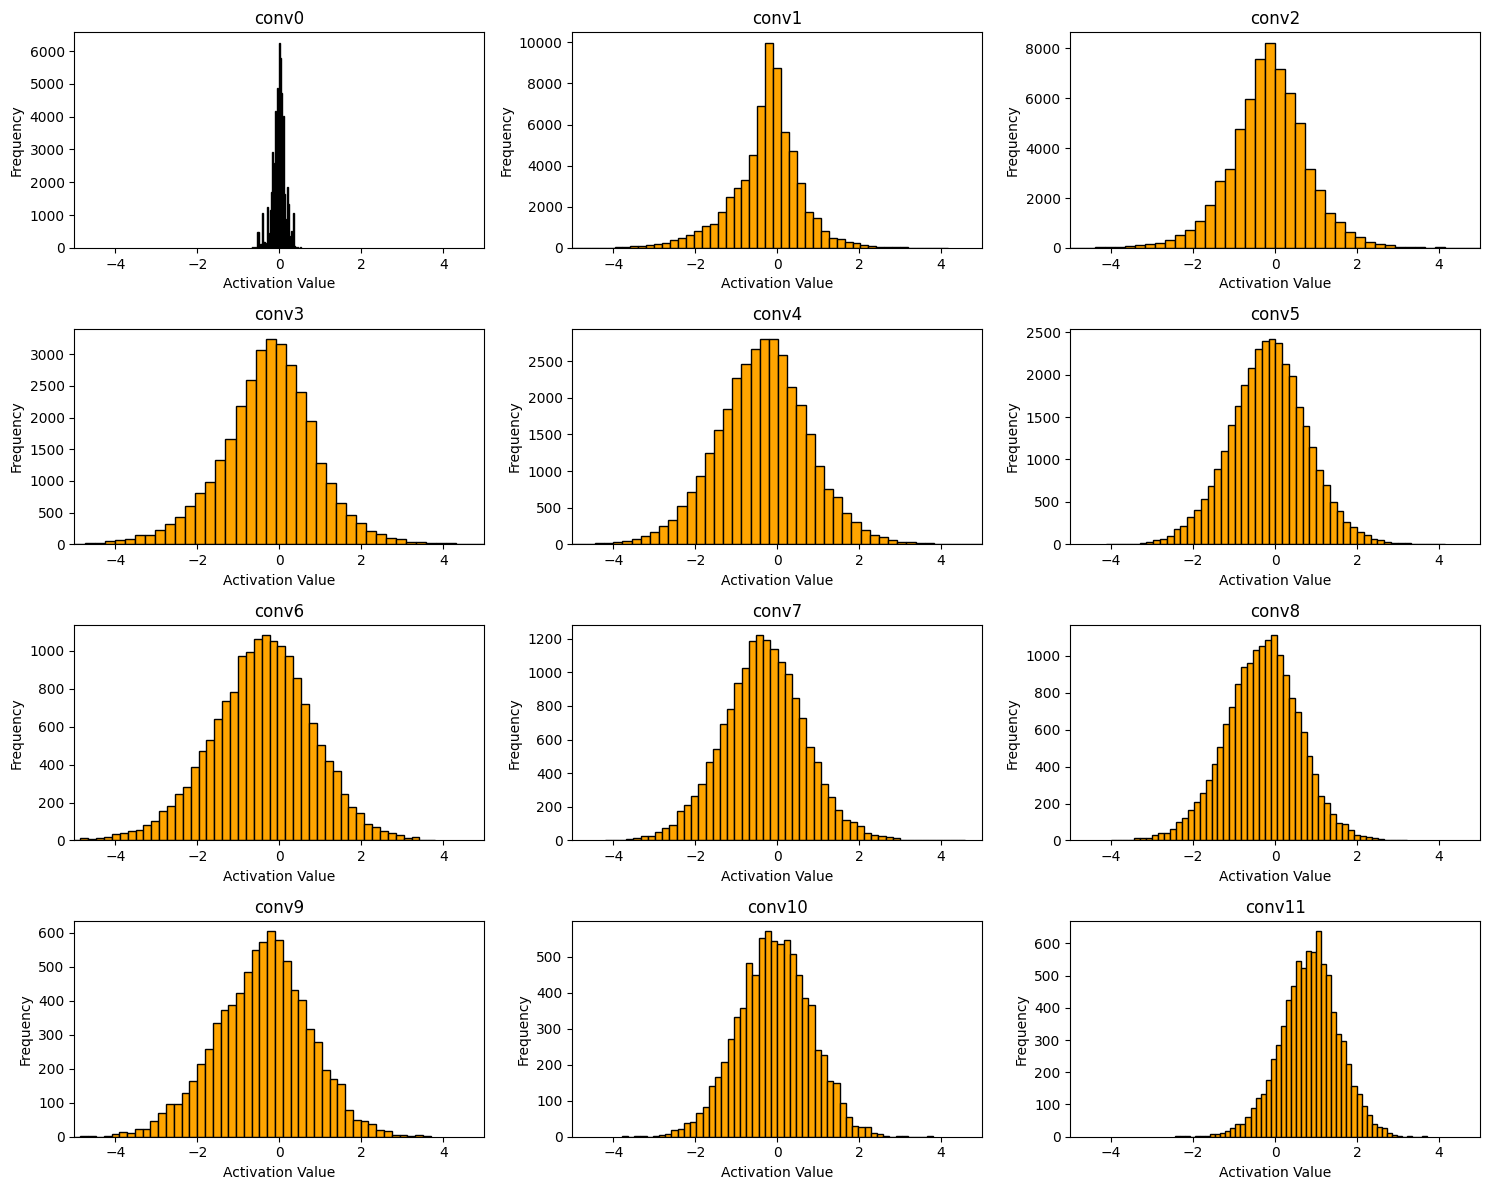

In [18]:
plot_activation_distribution(vgg16_finegrained_pp.features,tensor_image)

### <a id='toc6_2_2_'></a>[Fine-tuned](#toc0_)

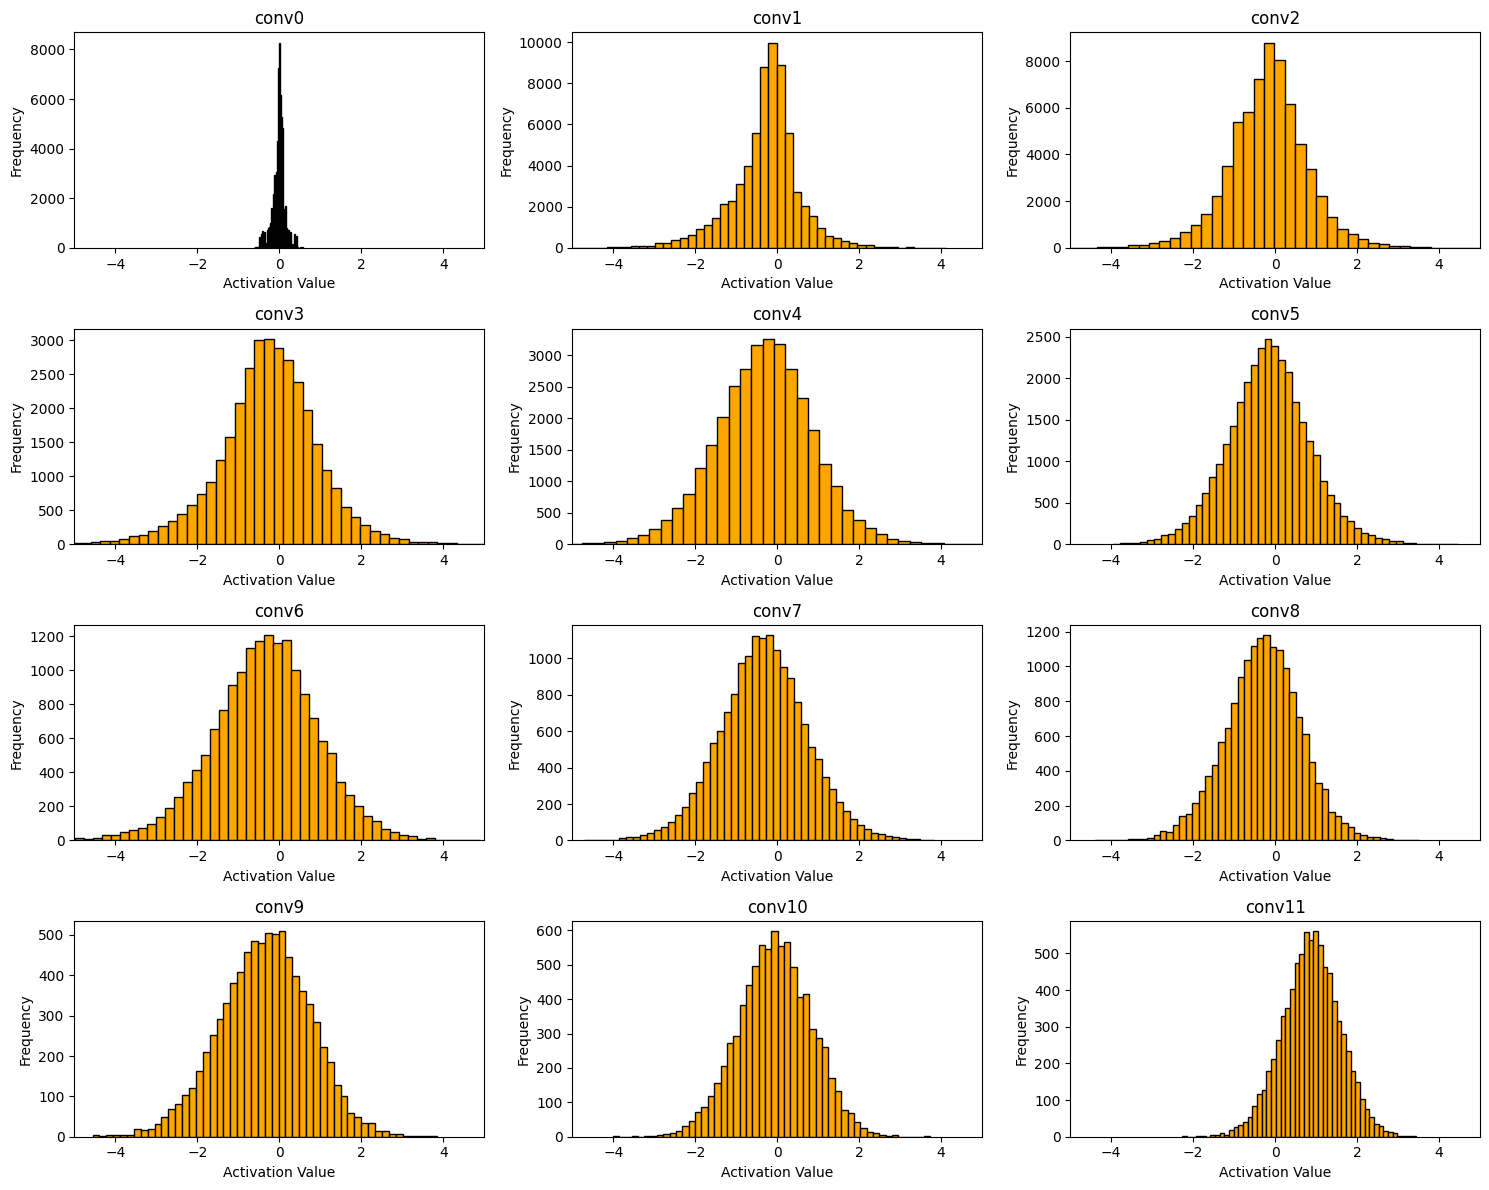

In [19]:
plot_activation_distribution(vgg16_finegrained.features,tensor_image)

## <a id='toc6_3_'></a>[Kernel](#toc0_)

### <a id='toc6_3_1_'></a>[Post-Pruning](#toc0_)

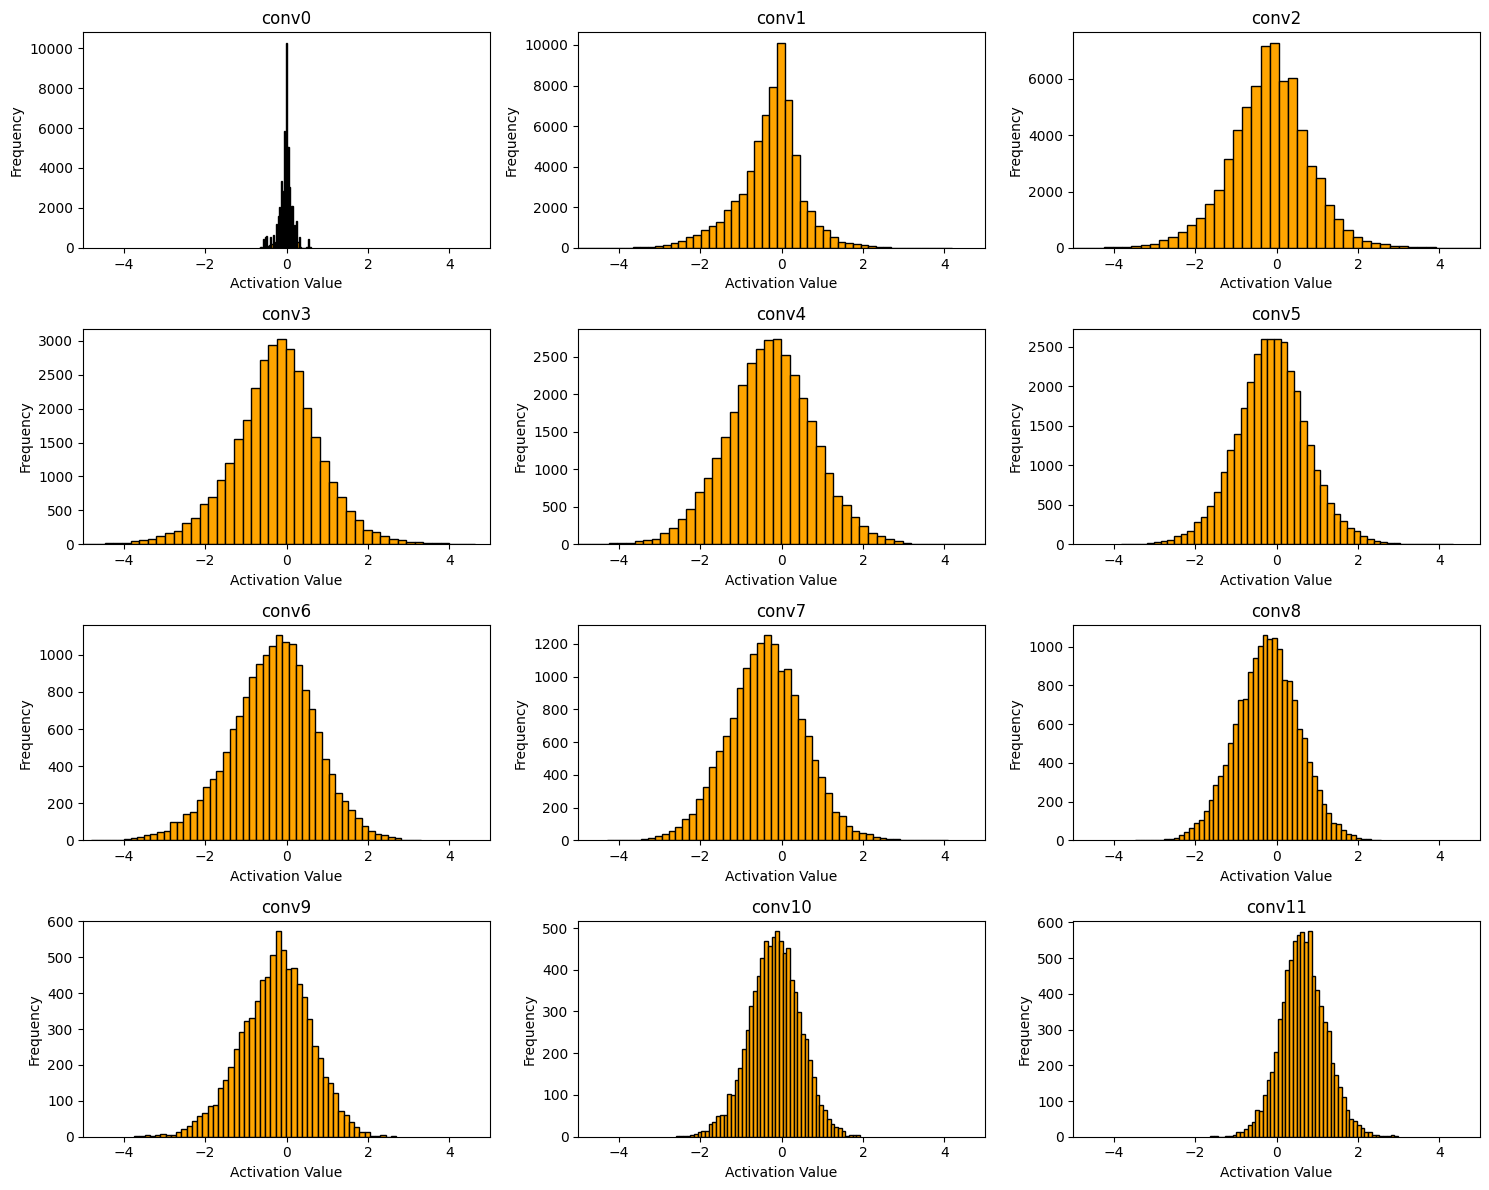

In [20]:
plot_activation_distribution(vgg16_kernel_pp.features,tensor_image)

### <a id='toc6_3_2_'></a>[Fine-tuned](#toc0_)

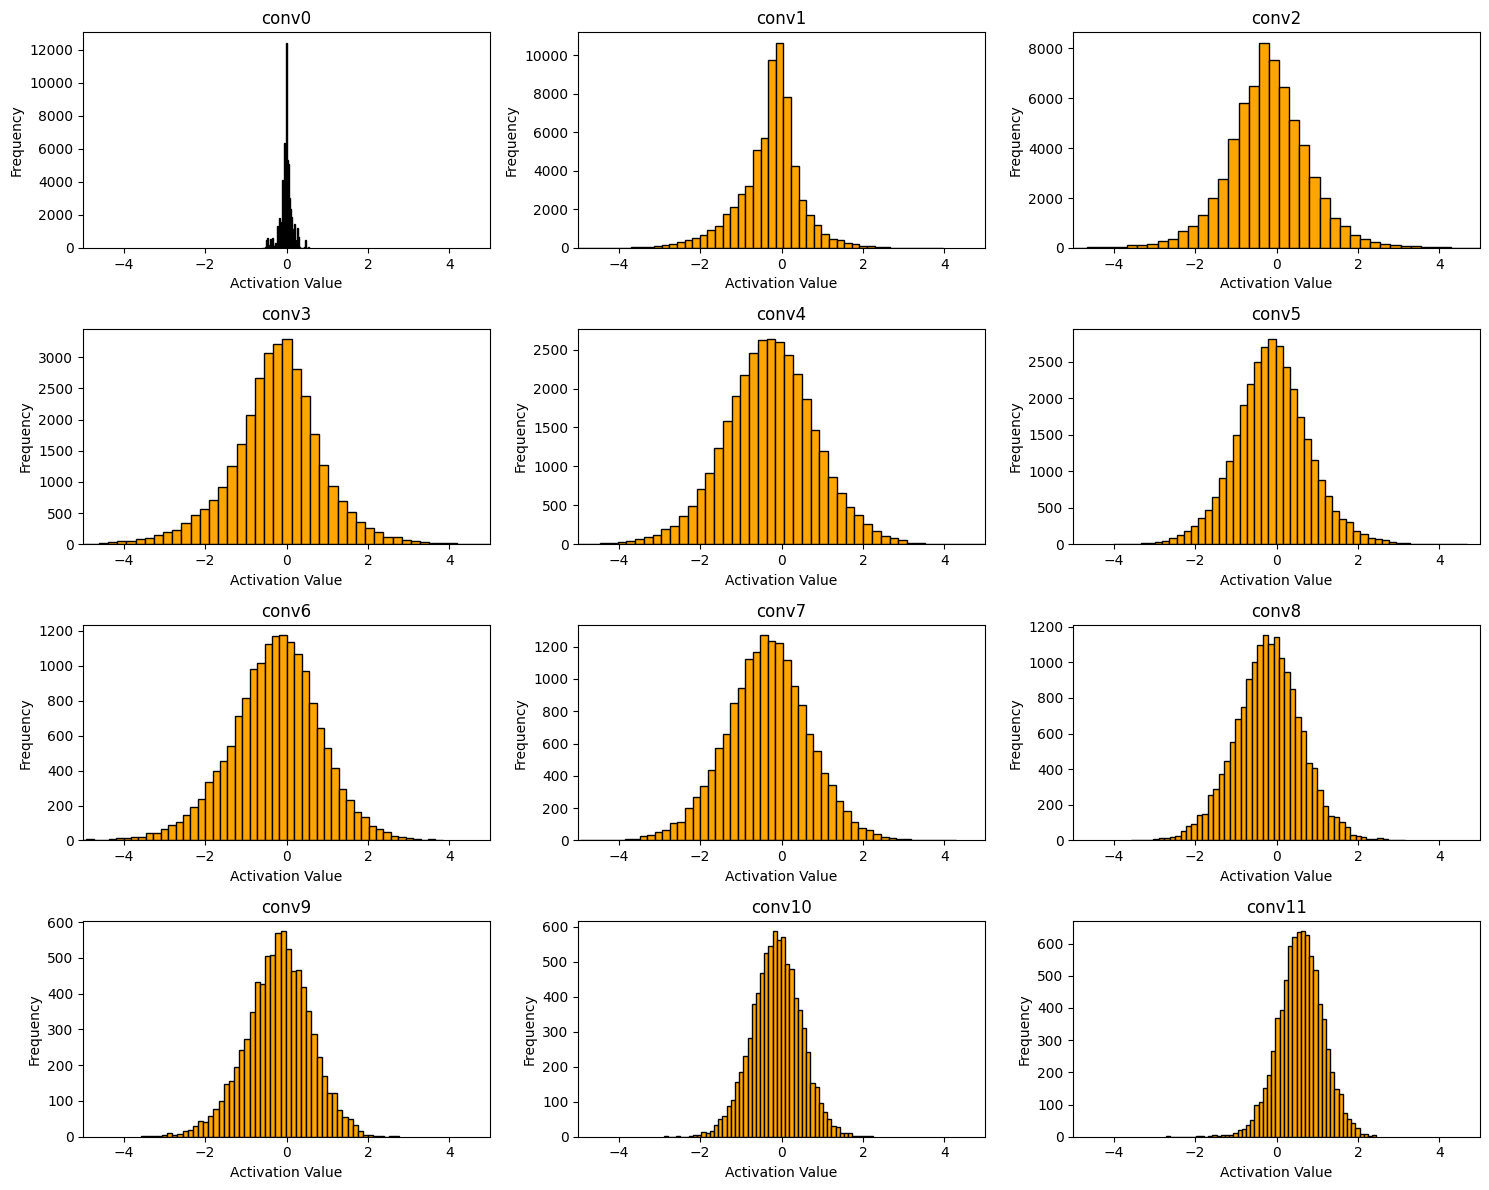

In [21]:
plot_activation_distribution(vgg16_kernel.features,tensor_image)

## <a id='toc6_4_'></a>[Filter](#toc0_)

### <a id='toc6_4_1_'></a>[Post-Pruning](#toc0_)

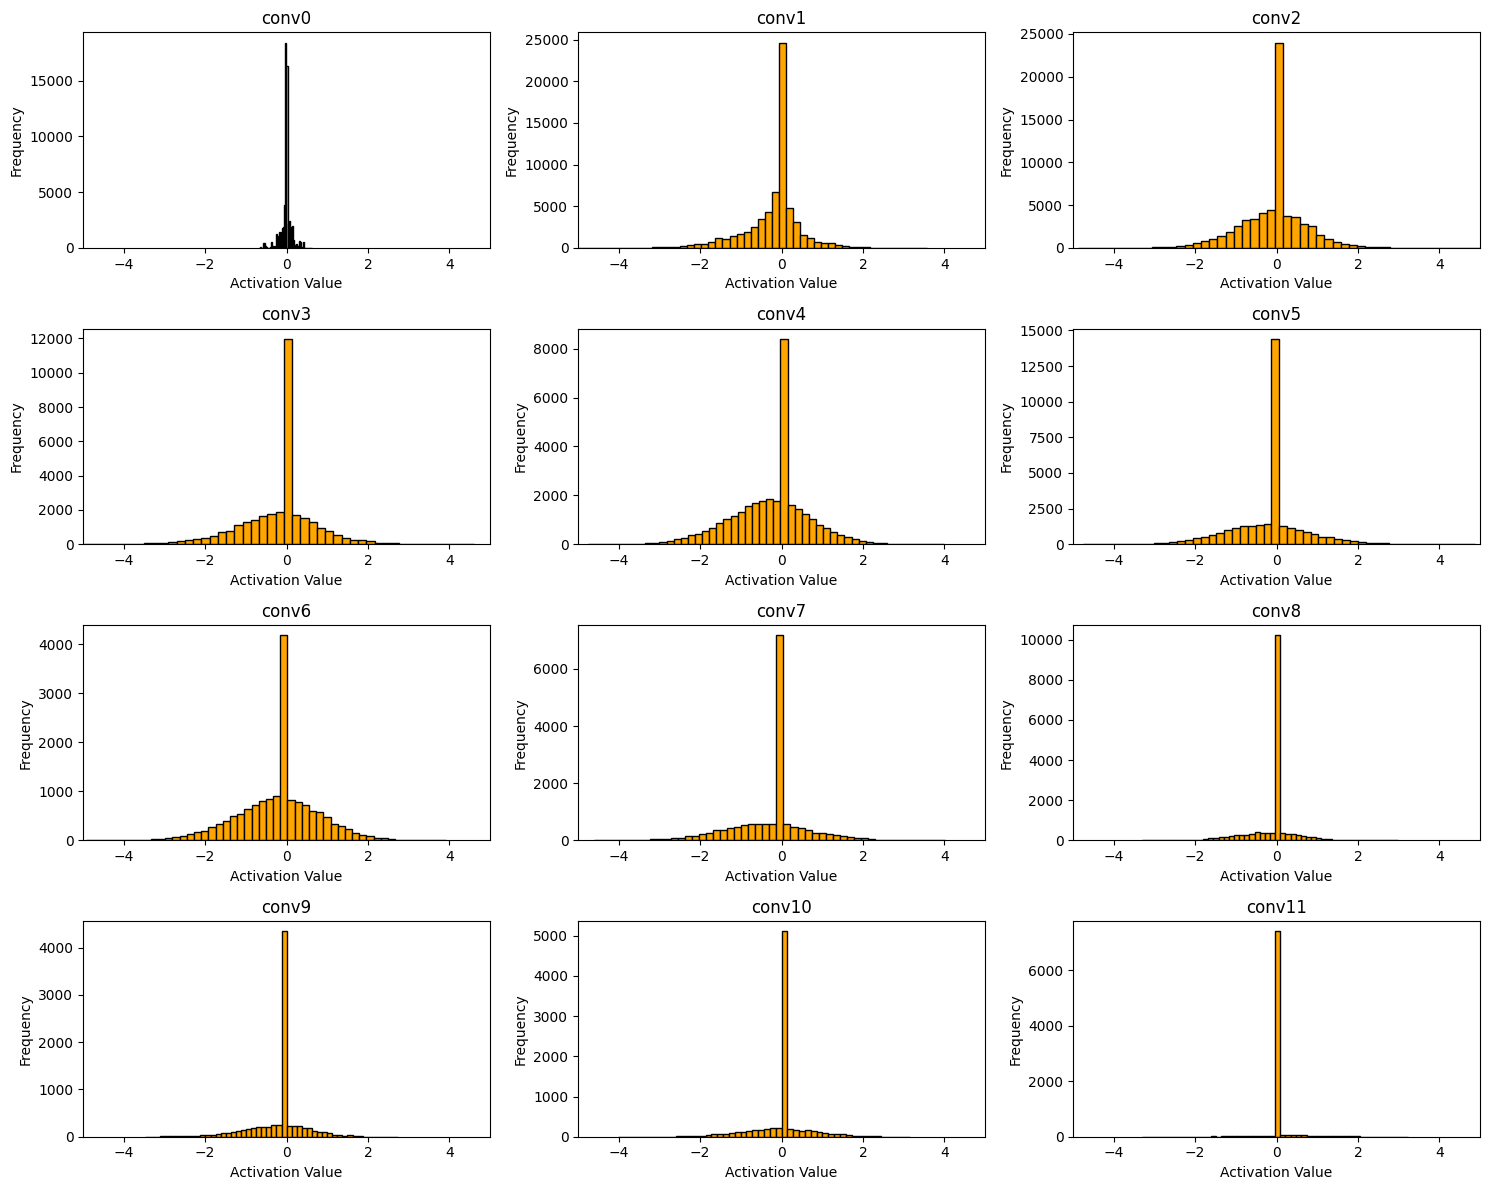

In [22]:
plot_activation_distribution(vgg16_filter_pp.features,tensor_image)

### <a id='toc6_4_2_'></a>[Fine-tuned](#toc0_)

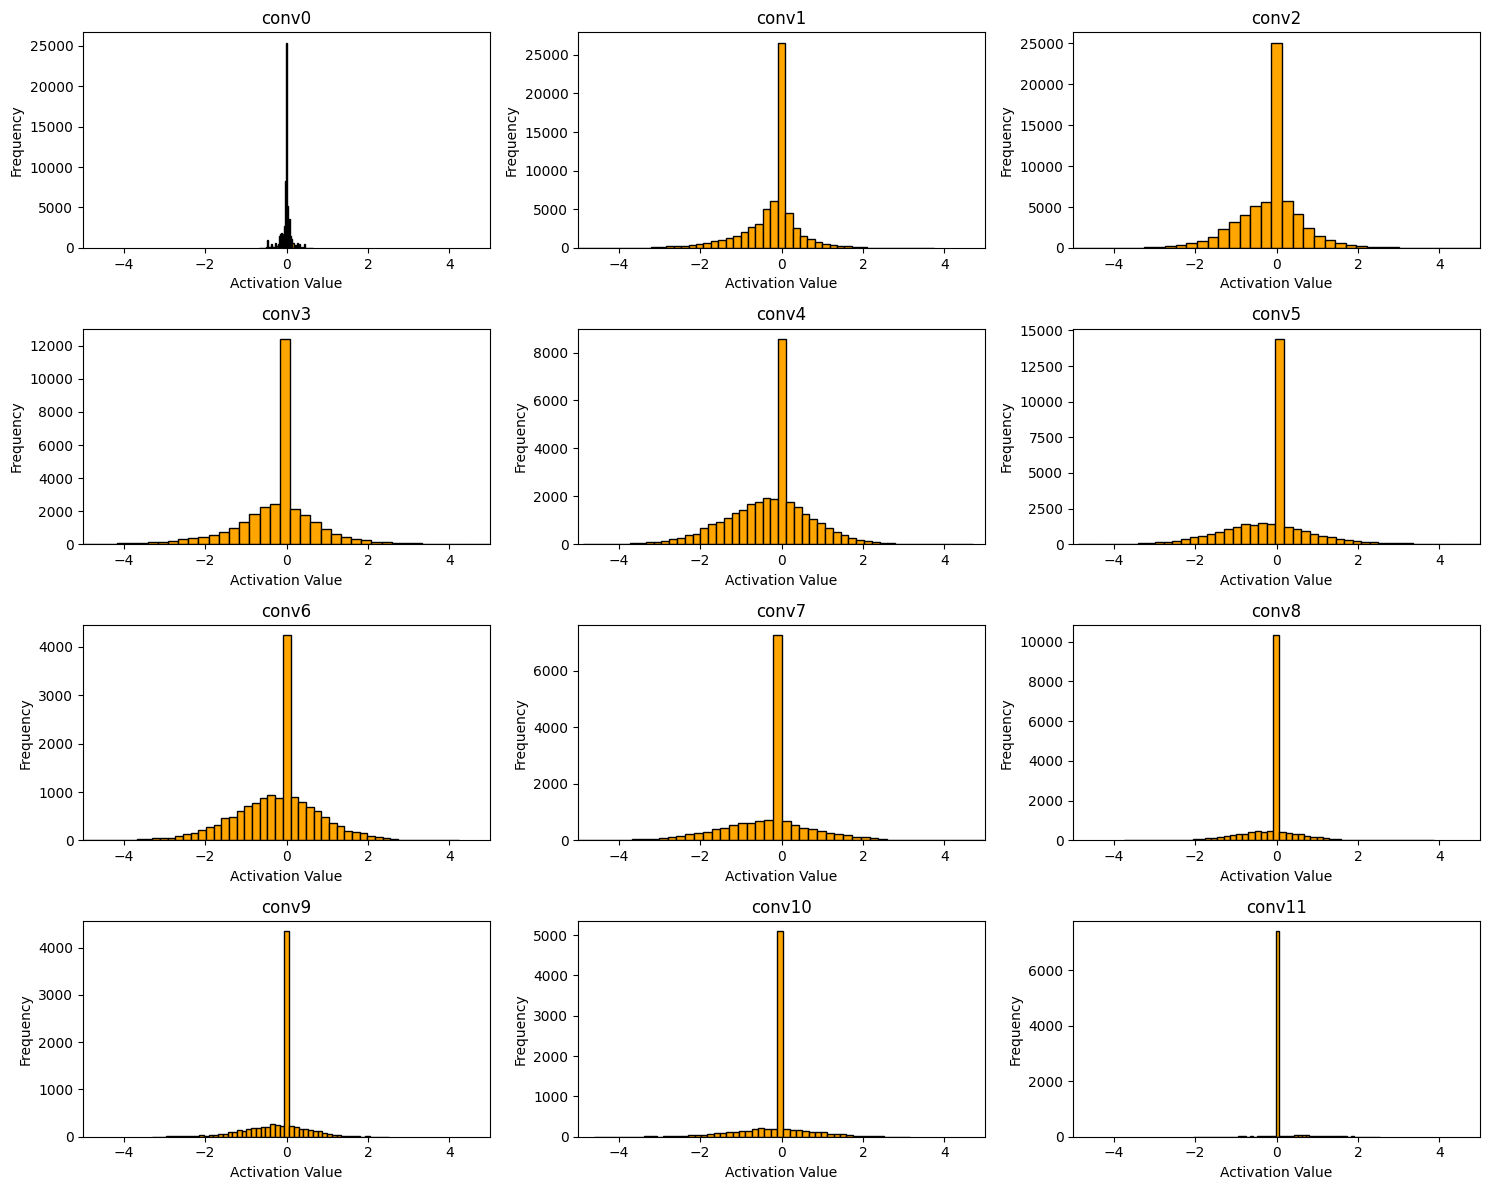

In [23]:
plot_activation_distribution(vgg16_filter.features,tensor_image)